# Quantum Auto-Regressive Model Training
**Objective:** Train a Hybrid Quantum-Classical Neural Network to predict the next token in a molecular sequence, conditioned on global molecular properties (logP, QED, MW).

**Architecture:**
* **Input:** 5-bit token encodings + 3 continuous property values.
* **Ansatz:** A variational quantum circuit using Strongly Entangling Layers and Diagonal Phase rotations ($e^{-i \phi Z \otimes Z}$).
* **Training:** JAX-based optimization using the Adam optimizer.

In [1]:
from typing import Tuple, List, Dict, Any

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import QED
from rdkit.Chem import Draw
from IPython.display import display
import selfies as sf

import numpy as np
import math
from math import ceil, log2, comb
import re
import pandas as pd
import optax
import csv
import json
import itertools
from functools import partial
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

import pennylane as qml
from pennylane.templates import StronglyEntanglingLayers

import jax
import jax.random as random
from jax import random
import jax.numpy as jnp
import jax.nn as jnn
from jax.nn.initializers import normal


# Data Preparation

In [2]:
# Load metadata from JSON
N_MOLECS = 1000
META_DATA_PATH = f"../data/metadata_selfies_{N_MOLECS}.json"

with open(META_DATA_PATH, "r") as f:
    metadata = json.load(f)

VOCABULARY_SIZE = metadata['vocabulary_size']
BITS_PER_TOKEN = metadata['bits_per_token']
MAX_LEN = metadata['max_sequence_length']
ALPHABET = metadata['alphabet']
min_logp = metadata['min_logP']
max_logp = metadata['max_logP']
min_qed = metadata['min_qed']
max_qed = metadata['max_qed']
min_mw = metadata['min_mw']
max_mw = metadata['max_mw']

print("Vocabulary Size:", VOCABULARY_SIZE)
print("Bits per Token:", BITS_PER_TOKEN)
print("Max Sequence Length:", MAX_LEN)
print("Alphabet:", ALPHABET)


Vocabulary Size: 30
Bits per Token: 5
Max Sequence Length: 31
Alphabet: ['<SOS>', '[#Branch1]', '[#Branch2]', '[#C]', '[#N]', '[=Branch1]', '[=Branch2]', '[=C]', '[=N]', '[=O]', '[=P]', '[=Ring1]', '[=S]', '[Br]', '[Branch1]', '[Branch2]', '[C]', '[Cl]', '[F]', '[I]', '[NH1]', '[N]', '[O]', '[PH1]', '[P]', '[Ring1]', '[Ring2]', '[S]', '<EOS>', '<PAD>']


In [3]:
# --- Auxiliary functions ---

def normalize(value, min_val, max_val, target_max=np.pi):
    ''' Normalize a value to a range [0, [0, pi] to later encode them as rotation angles'''
    norm = (value - min_val) / (max_val - min_val) * target_max
    return float(f"{norm:.3f}")

def denormalize(norm_value, min_val, max_val, target_max=np.pi):
    ''' Denormalize a value from [0, pi] back to its original range'''
    return (norm_value * (max_val - min_val) / target_max) + min_val

def token_to_index(token):
    ''' Map a SELFIES token to its corresponding index in the ALPHABET'''
    if token in ALPHABET:
        return ALPHABET.index(token)
    else:
        return None

def bits_to_index(bits):
    powers = 2 ** jnp.arange(len(bits) - 1, -1, -1)
    return jnp.dot(bits, powers).astype(jnp.int32)

In [4]:
PAD_index = token_to_index("<PAD>")
SOS_index = token_to_index("<SOS>")
EOS_index = token_to_index("<EOS>")

In [5]:
def load_dataset_bits_batch(csv_path, n_bits=BITS_PER_TOKEN):
    """
    Read the dataset from a CSV file and convert it into bit representations for quantum processing.
    Args:
        csv_path (str): Path to the CSV file containing the dataset.
        n_bits (int): Number of bits used to represent each token.
    Returns:
        Tuple containing:
            - X_bits (jnp.ndarray): Input bit representations of shape (N_Molecules, MAX_LEN-1, n_bits).
            - Props (jnp.ndarray): Molecular properties of shape (N_Molecules, 3).
            - Y_indices (jnp.ndarray): Target token indices of shape (N_Molecules, MAX_LEN-1).
    """
    
    df = pd.read_csv(csv_path, dtype=str)
    print("Dataset loaded with shape:", df.shape)
    
    # Properties: logP, qed, mw
    # Shape: (N_Moleculas, 3)
    # Types: float
    props = df.iloc[:, :3].astype(float).values
    
    # Tokens
    # Shape: (N_Moleculas, MAX_LEN)
    # Types: string (e.g., "00101")
    token_cols = df.iloc[:, 3:].values
    
    # Auxiliary function to convert a string of '0's and '1's to a list
    def str_to_bit_list(s):
        return [int(c) for c in s]

    # 3D array to hold all bits
    all_bits = np.array([
        [str_to_bit_list(token) for token in row] 
        for row in token_cols
    ])
    
    # X_bits: Input for the model.
    # Take all tokens except the last one.
    X_bits = all_bits[:, :-1, :] 
    
    # Y_ind: Target indices for the model.
    # Take all tokens except the first one.
    # Convert from bit strings to integer indices (for loss calculation).
    Y_indices = np.array([[int(t, 2) for t in row[1:]] for row in token_cols])

    return jnp.array(X_bits), jnp.array(props), jnp.array(Y_indices)


In [6]:
data_path_train = f"../data/structured_data_selfies_{N_MOLECS}_train.csv"
print("Loaded training data:")
X_bits, Props, Y_ind = load_dataset_bits_batch(data_path_train)

print("X_bits shape:", X_bits.shape) # (N, L, 5)
print("Props shape:", Props.shape)   # (N, 3)
print("Y_ind shape:", Y_ind.shape)   # (N, L)
print("------------------------------")


data_path_val = f"../data/structured_data_selfies_{N_MOLECS}_val.csv"
print("Loaded validation data:")
X_bits_val, Props_val, Y_ind_val = load_dataset_bits_batch(data_path_val)

print("X_bits shape:", X_bits_val.shape) # (N, L, 5)
print("Props shape:", Props_val.shape)   # (N, 3)
print("Y_ind shape:", Y_ind_val.shape)   # (N, L)
print("------------------------------")


data_path_test = f"../data/structured_data_selfies_{N_MOLECS}_test.csv"
print("Loaded validation data:")
X_bits_test, Props_test, Y_ind_test = load_dataset_bits_batch(data_path_test)

print("X_bits shape:", X_bits_test.shape) # (N, L, 5)
print("Props shape:", Props_test.shape)   # (N, 3)
print("Y_ind shape:", Y_ind_test.shape)   # (N, L)

Loaded training data:
Dataset loaded with shape: (667, 34)
X_bits shape: (667, 30, 5)
Props shape: (667, 3)
Y_ind shape: (667, 30)
------------------------------
Loaded validation data:
Dataset loaded with shape: (143, 34)
X_bits shape: (143, 30, 5)
Props shape: (143, 3)
Y_ind shape: (143, 30)
------------------------------
Loaded validation data:
Dataset loaded with shape: (143, 34)
X_bits shape: (143, 30, 5)
Props shape: (143, 3)
Y_ind shape: (143, 30)


## Quantum Circuit

### The Quantum Circuit (Variational Ansatz)

This is the core of the implementation. The circuit accepts:
1.  **Molecular Properties:** Encoded via $R_y(\theta)$ rotations.
2.  **Current Token:** Encoded via Basis Embedding.
3.  **Context Vector:** Encoded via rotations.

The ansatz consists of $L$ layers of:
1.  **Unitary $V(\theta)$:** Strongly Entangling layers to mix information.
2.  **Diagonal $\Sigma(\gamma)$:** Multi-Z rotations to introduce non-linearity and entanglement specific to the Ising Hamiltonian structure often found in quantum dynamics.


To overcome the limited expressibility of NISQ circuits, we implemented a **Data Re-uploading scheme** where conditional information (molecular properties and attention context) is encoded into the circuit depth-wise. This allows the quantum model to approximate higher-degree polynomials of the input features, essential for capturing the complex discrete logic of SMILES syntax.

In [8]:
def zstring_combos(wires):
    """
    Return an ordered list of wire-tuples for all Z-strings up to order H_LOCAL.
    Order: all 1-local, then all 2-local, ..., up to H_LOCAL.
    """
    L = []
    for k in range(1, H_LOCAL + 1):
        L.extend(itertools.combinations(wires, k))
    return [tuple(c) for c in L]

def num_zstrings(n_wires):
    """
    Count how many Z-strings up to order H_LOCAL.
    """
    return sum(comb(n_wires, k) for k in range(1, H_LOCAL + 1))

In [9]:
# Circuit parameters ----------------------------------------------------------------------
N_LAYERS = 6  # number of variational layers
H_LOCAL = 3 # h_local sets the maximum number of qubits that can interact in each Z term
# ------------------------------------------------------------------------------------------


# Name the qubit wires explicitly
n_prop_qubits = 3  # number of qubits needed to encode properties (logP, QED, MW)
n_ancillas = 3  # number of ancilla qubits that represent the environment
n_total_qubits = n_prop_qubits + BITS_PER_TOKEN + n_ancillas

prop_wires = [f"prop_{i}" for i in range(n_prop_qubits)]
token_wires = [f"token_{i}" for i in range(BITS_PER_TOKEN)]
ancilla_wires = [f"ancilla_{i}" for i in range(n_ancillas)]
all_wires = prop_wires + token_wires + ancilla_wires

dev = qml.device("default.qubit", wires=all_wires)
#dev = qml.device("lightning.qubit", wires=all_wires)


def molecular_property_encoder(props, prop_scaling):
    """Encode continuous props on property qubits via RY rotations"""
    # Element-wise multiplication of property value * learnable scale
    scaled_props = props * prop_scaling

    for wire, val in zip(prop_wires, scaled_props):
        qml.RY(val, wires=wire)


def token_encoder(token_bits):
    """Soft basis encoding using RX rotation"""
    for i in range(BITS_PER_TOKEN):
        angle = token_bits[i] * jnp.pi 
        qml.RX(angle, wires=token_wires[i])


def operator_layer(theta_params, theta_prop, wires):
    """
    Variational layer where:
      - theta_params[...] are rotations for token + ancilla qubits
      - theta_prop encodes property→token entanglement
    """
    token_ancilla_ws = token_wires + ancilla_wires

    # Property → token entanglement 
    for p, prop_wire in enumerate(prop_wires):
        for t, t_a_wire in enumerate(token_ancilla_ws):
            qml.CRX(theta_prop[p, t, 0], wires=[prop_wire, t_a_wire])
            qml.CRY(theta_prop[p, t, 1], wires=[prop_wire, t_a_wire])

    # Strongly entangling layers on token + ancilla qubits
    qml.StronglyEntanglingLayers(
        weights=theta_params[None,:,:],  # shape: (n_token_ancilla, 3)
        wires=token_ancilla_ws
    )

def Sigma_layer_vec(gamma_vec, token_ancilla_ws, time=1.0, combos=None):
    """
    Diagonal multi-Z unitary Σ = exp(i * sum_s gamma_s * Z^{⊗|s|} * t)
    using a flat parameter vector 'gamma_vec' aligned with 'combos'.
    """
    if combos is None:
        combos = zstring_combos(token_ancilla_ws)

    # Safety: ensure the vector length matches the number of combos
    assert gamma_vec.shape[0] == len(combos), \
        f"gamma_vec has length {gamma_vec.shape[0]} but expected {len(combos)}"

    # MultiRZ(phi) = exp(-i * phi/2 * Z^{⊗k}); choose phi = -2 * gamma * time
    for gamma, combo in zip(gamma_vec, combos):
        qml.MultiRZ(-2.0 * gamma * time, wires=list(combo))


@qml.qnode(dev, interface="jax", diff_method="backprop")
def autoregressive_model(token_bits, props, theta_params, theta_prop, sigma_params, prop_scaling):
    """
    QNode for the autoregressive model.
    Args:
        token_bits: Bit representation of input tokens (shape: BITS_PER_TOKEN,)
        props: Molecular properties (shape: 3,)
        theta_params: Variational parameters for operator layers (shape: N_LAYERS, n_token_ancilla, 3)
        theta_prop: Property entanglement parameters (shape: N_LAYERS, n_prop_qubits, n_token_ancilla, 2)
        sigma_params: Parameters for Sigma layers (shape: N_LAYERS, num_zstrings)
    Returns:
        Probabilities over token qubits and expectation values of property qubits.
    """
    token_encoder(token_bits)              # Basis-encode token bits

    token_ancilla_ws = token_wires + ancilla_wires
    combos = zstring_combos(token_ancilla_ws)

    for l in range(N_LAYERS):
        # Re-inject properties and context at every layer
        molecular_property_encoder(props, prop_scaling)
        
        # Forward V(θ)
        operator_layer(theta_params[l], theta_prop[l], wires=all_wires)

        # Diagonal Σ(γ,t): vector API
        Sigma_layer_vec(sigma_params[l], token_ancilla_ws, time=1.0, combos=combos)

        # Backward V(θ)†
        qml.adjoint(operator_layer)(theta_params[l], theta_prop[l], wires=all_wires)

    return qml.probs(wires=token_wires), [qml.expval(qml.PauliZ(w)) for w in prop_wires]


### Classical Embedding

In [ ]:
# 1. Define the embedding network function
def embedding_network_fn(x):
    embedding_size = N_LAYERS * (BITS_PER_TOKEN + n_ancillas) * 3 
    mlp = hk.Sequential([
        hk.Linear(32), jax.nn.relu,
        hk.Linear(16), jax.nn.relu,
        hk.Linear(embedding_size),  # Match θ shape
    ])
    return mlp(x)

# 2. Transform the function to make it usable in JAX/Haiku
embedding_network = hk.transform(embedding_network_fn)


# 3. Use the embedding to generate θ parameters
def get_context_embedding(prev_token_bits, embed_params):
    """
    prev_token_bits: jnp.array of shape (12,) — concatenated 2×6 bits
    Returns: reshaped embedding output to match θ shape
    """
    embedding_output = embedding_network.apply(embed_params, None, prev_token_bits)
    return embedding_output.reshape((N_LAYERS, BITS_PER_TOKEN + n_ancillas, 3))  # Shape for operator_layer



### Loss Function
We train on a composite loss function:
$$\mathcal{L}_{total} = \mathcal{L}_{CE} + \alpha \mathcal{L}_{Props}$$
1.  **Cross Entropy ($\mathcal{L}_{CE}$):** Ensures the model predicts the correct next token (with Label Smoothing to prevent overfitting).
2.  **Property Regression ($\mathcal{L}_{Props}$):** Regularizes the latent space by ensuring the quantum circuit still retains information about the desired properties (logP, QED, MW) at the output measurement stage.

In [10]:
def total_loss_fn(pred_probs, prop_expvals, target_indices, props, alpha=0.5, epsilon=0.1):
    """
    Computes normalized loss for a Batch of sequences.
    Handles prop_expvals whether it comes as a list or an array.
    Args:
        pred_probs: (Batch, Length, Vocab) - Predicted token probabilities
        prop_expvals: (Batch, Length, P) or List of (Batch, Length) arrays - Predicted property expectation values
        target_indices: (Batch, Length) - Target token indices
        props: (Batch, P) - Target molecular properties
        alpha: Weighting factor for property loss
        epsilon: Label smoothing factor for cross-entropy loss
    Returns:
        Normalized combined loss (scalar)
    """
    # Handle List vs Array Input
    if isinstance(prop_expvals, list) or isinstance(prop_expvals, tuple):
        # If it's a list of (B, L) arrays, stack them to get (B, L, P)
        prop_expvals = jnp.stack(prop_expvals, axis=-1)
        
    # 1. Get dimensions
    # Now prop_expvals is guaranteed to be (B, L, P)
    vocab_size = pred_probs.shape[-1] 
    B, L, P = prop_expvals.shape 
    
    # 2. Flatten dimensions for easier processing (B*L, Vocab)
    flat_probs = pred_probs.reshape(-1, vocab_size)
    flat_targets = target_indices.reshape(-1)
    
    # 3. Cross-Entropy with Label Smoothing
    target_one_hot = jax.nn.one_hot(flat_targets, vocab_size)
    
    smooth_target = jnp.full_like(flat_probs, epsilon / (vocab_size - 1))
    smooth_target = jnp.where(target_one_hot == 1, 1.0 - epsilon, smooth_target)
    
    loss_per_token = -jnp.sum(smooth_target * jnp.log(flat_probs + 1e-10), axis=-1)

    # 4. Property Loss (MSE)
    # Properties were encoded as RY(theta) rotations. Since the expectation value 
    # of PauliZ is cos(theta), we compare output <Z> to cos(input_props).
    target_props = jnp.cos(props)[:, None, :] 
    target_props = jnp.broadcast_to(target_props, (B, L, P))
    
    # Flatten both to (B*L, P) for calculation
    flat_target_props = target_props.reshape(-1, P)
    flat_expvals = prop_expvals.reshape(-1, P)
    
    # Mean MSE across the properties (axis=-1)
    prop_loss_per_token = jnp.mean((flat_expvals - flat_target_props) ** 2, axis=-1)

    # 5. Masking (Ignore PAD tokens)
    mask = (flat_targets != PAD_index).astype(jnp.float32)
    
    # Average only over REAL tokens
    num_real_tokens = jnp.sum(mask) + 1e-9
    mean_ce = jnp.sum(loss_per_token * mask) / num_real_tokens
    mean_prop = jnp.sum(prop_loss_per_token * mask) / num_real_tokens

    # 6. Combine & Normalize
    combined_loss = mean_ce + alpha * mean_prop
    
    max_loss_scale = jnp.log(vocab_size) + alpha * 4.0
    
    return combined_loss / max_loss_scale

    
def compute_accuracy_masked(pred_probs, target_indices):
    """
    Calculates accuracy over non-PAD tokens.
    Args:
        pred_probs: (Batch, Length, Vocab) - Predicted token probabilities
        target_indices: (Batch, Length) - Target token indices
    Returns:
        Normalized accuracy (scalar)
    """
    # Get the predicted token indices (highest probability)
    predicted_indices = jnp.argmax(pred_probs, axis=-1)
    
    # Compare predictions to targets
    correct_predictions = (predicted_indices == target_indices)
    
    # Make to ignore PAD tokens
    mask = (target_indices != PAD_index)
    
    # Sum correct predictions over non-PAD tokens
    numerator = jnp.sum(correct_predictions * mask)
    
    # Divide by number of non-PAD tokens (epsilon to avoid div by zero)
    denominator = jnp.sum(mask) + 1e-9
    
    return numerator / denominator


## Model Training and Validation

This section implements the core optimization process. For each epoch, the execution follows two distinct phases:

1.  **Training Phase:** The model iterates over the **Training Set**, calculating gradients and updating the variational parameters ($\theta$) to minimize the combined loss function.
2.  **Validation Phase:** The model evaluates its current state on the held-out **Validation Set**. This is a **pure inference** step (no backpropagation) that strictly measures performance without updating weights.

**Objective:** By monitoring Validation Loss alongside Training Loss, we assess the model's ability to **generalize** to unseen chemical structures. This allows us to implement **Checkpointing**: we save the model parameters *only* when the Validation Loss reaches a new minimum, effectively preventing overfitting by discarding epochs where the model begins to memorize the training data.

In [11]:
# Token embedding parameters
rng = jax.random.PRNGKey(0)
dummy_context = jnp.zeros((3 * BITS_PER_TOKEN,), dtype=jnp.float32)  # 3 prev. tokens
embedding_params = embedding_network.init(rng, dummy_context)

# Effective qubit counts in variational layers
n_token_ancilla = BITS_PER_TOKEN + n_ancillas

# Initialize theta and sigma params
key = jax.random.PRNGKey(42)
key, k_theta, k_theta_prop, k_sigma, k_scale = jax.random.split(key, 5)

# Trainable scaling factors for [logP, QED, MW] initialize around 1.0
prop_scaling = jax.random.normal(k_scale, (3,)) * 0.1 + 1.0

# Precompute Z-string combos once
token_ancilla_ws = token_wires + ancilla_wires
combos = zstring_combos(token_ancilla_ws)
n_strings = len(combos)

# Combine all trainable parameters into a single dictionary
combined_params = {
    'theta': jax.random.normal(k_theta, (N_LAYERS, n_token_ancilla, 3)) * 0.1,
    'theta_prop': jax.random.normal(k_theta_prop, (N_LAYERS, n_prop_qubits, n_token_ancilla, 4)) * 0.1,
    'sigma': jax.random.normal(k_sigma, (N_LAYERS, n_strings)) * 0.1,
    'embedding': embedding_params,
    'prop_scaling': prop_scaling
}

# Training hyperparams
N_EPOCHS = 200
BATCH_SIZE = 16  # Puedes probar 16 o 64 según tu memoria RAM/VRAM
N_SAMPLES = len(X_bits)
STEPS_PER_EPOCH = N_SAMPLES // BATCH_SIZE

# Optimizer with Scheduler: warm up for 10 epochs, then decay
total_steps = N_EPOCHS * STEPS_PER_EPOCH
'''schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,                     # Start from 0 to warm up
    peak_value=1e-3,                    # Peak learning rate
    warmup_steps=10 * STEPS_PER_EPOCH, 
    decay_steps=total_steps,                
    end_value=1e-5                      # End with a very small rate to fine-tune
)'''
schedule = optax.cosine_decay_schedule(
    init_value=0.005, 
    decay_steps=200 * STEPS_PER_EPOCH, 
    alpha=0.1
)

optimizer = optax.adam(learning_rate=schedule)
#optimizer = optax.adam(1e-3)

opt_state = optimizer.init(combined_params)

In [12]:
def single_step_prediction(params, x_token_bits, x_props, theta_embedding):
    """
    Executes the quantum model for a SINGLE token of a SINGLE molecule.
    Args:
        params: Dictionary of model parameters.
        x_token_bits: Bit representation of the current token (shape: BITS_PER_TOKEN,).
        x_props: Molecular properties (shape: 3,).
        context_vec: Attention context vector (shape: BITS_PER_TOKEN,).
    Returns:
        Tuple of:
            - Probabilities over token qubits (shape: VOCABULARY_SIZE,).
            - Expectation values of property qubits (shape: 3,).
    """
    theta = params['theta']
    theta_prop = params['theta_prop']
    sigma = params['sigma']
    prop_scaling = params['prop_scaling']
    
    # Call Quantum Node
    return autoregressive_model(
        x_token_bits, x_props, theta, theta_prop, sigma, theta_embedding, prop_scaling
    )

# Vectorize from single input to sequence and batch inputs
sequence_predict = jax.vmap(
    single_step_prediction, 
    in_axes=(None, 0, None, 0)
    # params: None      -> same params for all tokens
    # x_token_bits: 0   -> different token bits per token
    # x_props: None     -> same props for all tokens
    # context_vec: 0    -> different context per token
)

batch_predict = jax.vmap(
    sequence_predict, 
    in_axes=(None, 0, 0, 0)
    # params: None      -> same params for all tokens
    # x_token_bits: 0   -> different token bits per token
    # x_props: 0        -> different props per molecule
    # context_vec: 0    -> different context per token
)

In [13]:
# @partial allows uses JIT compilation while keeping some args static
@partial(jax.jit, static_argnums=(5,))
def training_step_batched(params, opt_state, x_bits_batch, prop_batch, y_target_indices, alpha=0.5):
    """
    Performs a single training step over a batch of data.
    Args:
        params: Model parameters
        opt_state: Optimizer state
        x_bits_batch: Input bits batch (B, L, 5)
        prop_batch: Molecular properties batch (B, 3)
        y_target_indices: Target token indices batch (B, L)
        PAD_index: Index of the PAD token
        alpha: Weight for property loss

    Returns:
        new_params: Updated model parameters
        loss: Computed loss for the batch
        opt_state: Updated optimizer state
        grads: Computed gradients
        acc: Accuracy for the batch
    """
    def loss_fn(params):
        # 1.1. Embedding table lookup
        theta_params = params['theta']
        embedding_params = params['embedding']

        theta_embedding = get_context_embedding(context_vector, embedding_params)
        theta_embedding = theta_params + theta_embedding

        # 1.5. Quantum Model Prediction
        pred_probs, expval_props = batch_predict(
            params, x_bits_batch, prop_batch, theta_embedding
        )

        # 1.6. Compute Loss
        final_loss = total_loss_fn(
            pred_probs, 
            expval_props, 
            y_target_indices, 
            prop_batch, 
            alpha
        )
        
        return final_loss, pred_probs

    # 1. Calculate loss and gradients
    (loss, pred_probs), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # 2. Update parameters
    updates, opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    
    # 3. Compute accuracy
    acc = compute_accuracy_masked(pred_probs, y_target_indices)

    return new_params, loss, opt_state, grads, acc

In [14]:
@partial(jax.jit, static_argnums=(4,))
def validation_step_batched(params, x_bits_batch, prop_batch, y_target_indices):
    """
    Pure inference step for validation (No Gradients).
    """
    # 1. Embedding & Positional Encoding (Same as training)
    theta_params = params['theta']
    embedding_params = params['embedding']

    theta_embedding = get_context_embedding(context_vector, embedding_params)
    theta_embedding = theta_params + theta_embedding

    # 3. Quantum Model Prediction
    pred_probs, expval_props = batch_predict(
        params, x_bits_batch, prop_batch, theta_embedding
    )

    # 4. Metrics
    loss = total_loss_fn(pred_probs, expval_props, y_target_indices, prop_batch)
    acc = compute_accuracy_masked(pred_probs, y_target_indices)
    
    return loss, acc

In [15]:
print(f"Starting training with {N_SAMPLES} molecules.")
print(f"Batch Size: {BATCH_SIZE} | Steps per epoch: {STEPS_PER_EPOCH}")

# Create directory for checkpoints if it doesn't exist
ckpt_dir = '../data/params/'
os.makedirs(ckpt_dir, exist_ok=True)

key = random.PRNGKey(42)

loss_history = []
acc_history = []
val_loss_history = []
val_acc_history = []

best_val_loss = float('inf')

for epoch in range(N_EPOCHS):
    epoch_start_time = time.time() # Track time per epoch

    # ------ Training Phase ------
    total_loss = 0.0
    total_acc = 0.0
    
    # Shuffle data at the start of each epoch to improve generalization
    key, subkey = random.split(key)
    perm = random.permutation(subkey, N_SAMPLES)
    X_shuffled = X_bits[perm]
    P_shuffled = Props[perm]
    Y_shuffled = Y_ind[perm]
    
    for step in range(0, N_SAMPLES, BATCH_SIZE):
        # 1. Create the Batch (Slicing)
        idx_end = min(step + BATCH_SIZE, N_SAMPLES)
        
        x_batch = X_shuffled[step:idx_end]      # (BATCH_SIZE, 30, 5)
        prop_batch = P_shuffled[step:idx_end]   # (BATCH_SIZE, 3)
        y_batch = Y_shuffled[step:idx_end]      # (BATCH_SIZE, 30)
        
        if len(x_batch) == 0: continue

        # 2. Train all the batch at once
        combined_params, loss, opt_state, grads, acc = training_step_batched(
            combined_params, 
            opt_state, 
            x_batch, 
            prop_batch, 
            y_batch
        )
        
        # 3. Accumulate metrics
        batch_n = len(x_batch)
        total_loss += loss * batch_n
        total_acc += acc * batch_n
        grad_norm = optax.global_norm(grads)

    # Average metrics over epoch
    avg_loss = total_loss / N_SAMPLES
    avg_acc = total_acc / N_SAMPLES

    loss_history.append(float(avg_loss))
    acc_history.append(float(avg_acc))

    # ------ Validation Phase ------
    val_total_loss = 0.0
    val_total_acc = 0.0
    N_VAL = len(X_bits_val)
    
    # Iterate through Validation Data
    for v_step in range(0, N_VAL, BATCH_SIZE):
        v_idx_end = min(v_step + BATCH_SIZE, N_VAL)
        
        vx_batch = X_bits_val[v_step:v_idx_end]
        vp_batch = Props_val[v_step:v_idx_end]
        vy_batch = Y_ind_val[v_step:v_idx_end]
        
        if len(vx_batch) == 0: continue

        # Pure Inference (No optimizer update, no gradients)
        v_loss, v_acc = validation_step_batched(
            combined_params, 
            vx_batch, 
            vp_batch, 
            vy_batch, 
            PAD_index
        )
        
        v_batch_n = len(vx_batch)
        val_total_loss += v_loss * v_batch_n
        val_total_acc += v_acc * v_batch_n

    val_avg_loss = val_total_loss / N_VAL
    val_avg_acc = val_total_acc / N_VAL
    val_loss_history.append(float(val_avg_loss))
    val_acc_history.append(float(val_avg_acc))

    epoch_time = time.time() - epoch_start_time

    # Print both Train and Val metrics
    print(f"Epoch {epoch+1:03d} | Train Loss: {avg_loss:.4f} | Val Loss: {val_avg_loss:.4f} | Val Acc: {val_avg_acc:.4f} | Time: {epoch_time:.2f}s")

    # Checkpointing (Save Best Model)
    if val_avg_loss < best_val_loss:
        best_val_loss = val_avg_loss
        
        # Save with a specific name indicating it is the "best"
        fecha = time.strftime("%d%m%Y")
        save_path = os.path.join(ckpt_dir, f"selfies_params_{N_MOLECS}_BEST.pkl")
        
        with open(save_path, "wb") as f:
            pickle.dump(combined_params, f)

Starting training with 667 molecules.
Batch Size: 16 | Steps per epoch: 41
Epoch 001 | Train Loss: 0.6389 | Val Loss: 0.5805 | Val Acc: 0.3346 | Time: 199.44s
Epoch 002 | Train Loss: 0.5567 | Val Loss: 0.5453 | Val Acc: 0.3785 | Time: 132.70s
Epoch 003 | Train Loss: 0.5308 | Val Loss: 0.5282 | Val Acc: 0.3850 | Time: 132.08s
Epoch 004 | Train Loss: 0.5180 | Val Loss: 0.5179 | Val Acc: 0.3834 | Time: 112.22s
Epoch 005 | Train Loss: 0.5093 | Val Loss: 0.5099 | Val Acc: 0.3871 | Time: 115.26s
Epoch 006 | Train Loss: 0.5025 | Val Loss: 0.5020 | Val Acc: 0.4129 | Time: 135.83s
Epoch 007 | Train Loss: 0.4955 | Val Loss: 0.4962 | Val Acc: 0.4283 | Time: 128.20s
Epoch 008 | Train Loss: 0.4899 | Val Loss: 0.4909 | Val Acc: 0.4218 | Time: 116.46s
Epoch 009 | Train Loss: 0.4847 | Val Loss: 0.4864 | Val Acc: 0.4201 | Time: 102.98s
Epoch 010 | Train Loss: 0.4802 | Val Loss: 0.4821 | Val Acc: 0.4287 | Time: 106.13s
Epoch 011 | Train Loss: 0.4756 | Val Loss: 0.4797 | Val Acc: 0.4198 | Time: 113.34s
E

Starting training with 667 molecules.
Batch Size: 16 | Steps per epoch: 41
Epoch 001 | Train Loss: 0.6331 | Val Loss: 0.5843 | Val Acc: 0.3478 | Time: 105.45s
Epoch 002 | Train Loss: 0.5677 | Val Loss: 0.5598 | Val Acc: 0.3803 | Time: 50.39s
Epoch 003 | Train Loss: 0.5507 | Val Loss: 0.5478 | Val Acc: 0.3909 | Time: 53.73s
Epoch 004 | Train Loss: 0.5386 | Val Loss: 0.5363 | Val Acc: 0.3978 | Time: 59.04s
Epoch 005 | Train Loss: 0.5267 | Val Loss: 0.5260 | Val Acc: 0.3914 | Time: 70.87s
Epoch 006 | Train Loss: 0.5152 | Val Loss: 0.5127 | Val Acc: 0.4332 | Time: 51.92s
Epoch 007 | Train Loss: 0.4961 | Val Loss: 0.4907 | Val Acc: 0.4120 | Time: 51.75s
Epoch 008 | Train Loss: 0.4789 | Val Loss: 0.4756 | Val Acc: 0.4085 | Time: 47.74s
Epoch 009 | Train Loss: 0.4676 | Val Loss: 0.4652 | Val Acc: 0.4282 | Time: 50.03s
Epoch 010 | Train Loss: 0.4593 | Val Loss: 0.4596 | Val Acc: 0.4404 | Time: 53.78s
Epoch 011 | Train Loss: 0.4537 | Val Loss: 0.4557 | Val Acc: 0.4506 | Time: 58.07s
Epoch 012 | Train Loss: 0.4505 | Val Loss: 0.4545 | Val Acc: 0.4436 | Time: 56.22s
Epoch 013 | Train Loss: 0.4482 | Val Loss: 0.4524 | Val Acc: 0.4531 | Time: 50.39s
Epoch 014 | Train Loss: 0.4450 | Val Loss: 0.4520 | Val Acc: 0.4488 | Time: 49.95s
Epoch 015 | Train Loss: 0.4432 | Val Loss: 0.4503 | Val Acc: 0.4588 | Time: 59.42s
Epoch 016 | Train Loss: 0.4425 | Val Loss: 0.4489 | Val Acc: 0.4686 | Time: 51.62s
Epoch 017 | Train Loss: 0.4418 | Val Loss: 0.4487 | Val Acc: 0.4550 | Time: 68.15s
Epoch 018 | Train Loss: 0.4412 | Val Loss: 0.4488 | Val Acc: 0.4543 | Time: 54.42s
Epoch 019 | Train Loss: 0.4417 | Val Loss: 0.4498 | Val Acc: 0.4559 | Time: 56.53s
Epoch 020 | Train Loss: 0.4402 | Val Loss: 0.4497 | Val Acc: 0.4651 | Time: 52.25s
Epoch 021 | Train Loss: 0.4407 | Val Loss: 0.4474 | Val Acc: 0.4679 | Time: 49.47s
Epoch 022 | Train Loss: 0.4392 | Val Loss: 0.4470 | Val Acc: 0.4622 | Time: 54.21s
Epoch 023 | Train Loss: 0.4387 | Val Loss: 0.4481 | Val Acc: 0.4588 | Time: 51.34s
Epoch 024 | Train Loss: 0.4395 | Val Loss: 0.4473 | Val Acc: 0.4755 | Time: 48.25s
Epoch 025 | Train Loss: 0.4384 | Val Loss: 0.4450 | Val Acc: 0.4785 | Time: 48.33s
Epoch 026 | Train Loss: 0.4381 | Val Loss: 0.4467 | Val Acc: 0.4583 | Time: 51.40s
Epoch 027 | Train Loss: 0.4381 | Val Loss: 0.4456 | Val Acc: 0.4813 | Time: 51.10s
Epoch 028 | Train Loss: 0.4377 | Val Loss: 0.4460 | Val Acc: 0.4688 | Time: 48.39s
Epoch 029 | Train Loss: 0.4379 | Val Loss: 0.4449 | Val Acc: 0.4784 | Time: 50.54s
Epoch 030 | Train Loss: 0.4372 | Val Loss: 0.4450 | Val Acc: 0.4855 | Time: 50.66s
Epoch 031 | Train Loss: 0.4372 | Val Loss: 0.4447 | Val Acc: 0.4769 | Time: 71.22s
Epoch 032 | Train Loss: 0.4375 | Val Loss: 0.4455 | Val Acc: 0.4693 | Time: 53.60s
Epoch 033 | Train Loss: 0.4373 | Val Loss: 0.4445 | Val Acc: 0.4670 | Time: 48.30s
Epoch 034 | Train Loss: 0.4371 | Val Loss: 0.4452 | Val Acc: 0.4940 | Time: 56.22s
Epoch 035 | Train Loss: 0.4367 | Val Loss: 0.4456 | Val Acc: 0.4804 | Time: 55.51s
Epoch 036 | Train Loss: 0.4368 | Val Loss: 0.4451 | Val Acc: 0.4762 | Time: 48.40s
Epoch 037 | Train Loss: 0.4361 | Val Loss: 0.4463 | Val Acc: 0.4896 | Time: 58.26s
Epoch 038 | Train Loss: 0.4368 | Val Loss: 0.4456 | Val Acc: 0.4732 | Time: 63.27s
Epoch 039 | Train Loss: 0.4361 | Val Loss: 0.4446 | Val Acc: 0.4739 | Time: 49.40s
Epoch 040 | Train Loss: 0.4360 | Val Loss: 0.4446 | Val Acc: 0.4721 | Time: 54.06s
Epoch 041 | Train Loss: 0.4364 | Val Loss: 0.4441 | Val Acc: 0.4831 | Time: 50.32s
Epoch 042 | Train Loss: 0.4353 | Val Loss: 0.4443 | Val Acc: 0.4764 | Time: 49.06s
Epoch 043 | Train Loss: 0.4357 | Val Loss: 0.4446 | Val Acc: 0.4715 | Time: 48.98s
Epoch 044 | Train Loss: 0.4356 | Val Loss: 0.4442 | Val Acc: 0.4737 | Time: 51.99s
Epoch 045 | Train Loss: 0.4357 | Val Loss: 0.4440 | Val Acc: 0.4688 | Time: 54.72s
Epoch 046 | Train Loss: 0.4355 | Val Loss: 0.4432 | Val Acc: 0.4738 | Time: 67.69s
Epoch 047 | Train Loss: 0.4350 | Val Loss: 0.4440 | Val Acc: 0.4671 | Time: 50.25s
Epoch 048 | Train Loss: 0.4350 | Val Loss: 0.4442 | Val Acc: 0.4702 | Time: 46.33s
Epoch 049 | Train Loss: 0.4360 | Val Loss: 0.4440 | Val Acc: 0.4846 | Time: 47.13s
Epoch 050 | Train Loss: 0.4352 | Val Loss: 0.4439 | Val Acc: 0.4698 | Time: 49.90s
Epoch 051 | Train Loss: 0.4349 | Val Loss: 0.4461 | Val Acc: 0.4767 | Time: 47.93s
Epoch 052 | Train Loss: 0.4349 | Val Loss: 0.4442 | Val Acc: 0.4642 | Time: 49.98s
Epoch 053 | Train Loss: 0.4349 | Val Loss: 0.4449 | Val Acc: 0.4672 | Time: 46.86s
Epoch 054 | Train Loss: 0.4345 | Val Loss: 0.4436 | Val Acc: 0.4727 | Time: 46.87s
Epoch 055 | Train Loss: 0.4347 | Val Loss: 0.4439 | Val Acc: 0.4862 | Time: 47.71s
Epoch 056 | Train Loss: 0.4343 | Val Loss: 0.4434 | Val Acc: 0.4867 | Time: 48.94s
Epoch 057 | Train Loss: 0.4346 | Val Loss: 0.4435 | Val Acc: 0.4722 | Time: 45.64s
Epoch 058 | Train Loss: 0.4340 | Val Loss: 0.4427 | Val Acc: 0.4755 | Time: 48.86s
Epoch 059 | Train Loss: 0.4339 | Val Loss: 0.4431 | Val Acc: 0.4892 | Time: 45.78s
Epoch 060 | Train Loss: 0.4346 | Val Loss: 0.4437 | Val Acc: 0.4712 | Time: 46.91s
Epoch 061 | Train Loss: 0.4338 | Val Loss: 0.4436 | Val Acc: 0.4673 | Time: 56.16s
Epoch 062 | Train Loss: 0.4334 | Val Loss: 0.4428 | Val Acc: 0.4770 | Time: 45.31s
Epoch 063 | Train Loss: 0.4332 | Val Loss: 0.4418 | Val Acc: 0.4805 | Time: 45.99s
Epoch 064 | Train Loss: 0.4336 | Val Loss: 0.4419 | Val Acc: 0.4854 | Time: 44.91s
Epoch 065 | Train Loss: 0.4333 | Val Loss: 0.4418 | Val Acc: 0.4854 | Time: 45.76s
Epoch 066 | Train Loss: 0.4333 | Val Loss: 0.4412 | Val Acc: 0.4779 | Time: 52.26s
Epoch 067 | Train Loss: 0.4333 | Val Loss: 0.4418 | Val Acc: 0.4863 | Time: 48.14s
Epoch 068 | Train Loss: 0.4331 | Val Loss: 0.4421 | Val Acc: 0.4850 | Time: 46.12s
Epoch 069 | Train Loss: 0.4327 | Val Loss: 0.4421 | Val Acc: 0.4906 | Time: 46.33s
Epoch 070 | Train Loss: 0.4329 | Val Loss: 0.4419 | Val Acc: 0.4821 | Time: 44.97s
Epoch 071 | Train Loss: 0.4321 | Val Loss: 0.4412 | Val Acc: 0.4822 | Time: 51.68s
Epoch 072 | Train Loss: 0.4326 | Val Loss: 0.4425 | Val Acc: 0.4760 | Time: 47.44s
Epoch 073 | Train Loss: 0.4321 | Val Loss: 0.4400 | Val Acc: 0.4883 | Time: 45.70s
Epoch 074 | Train Loss: 0.4317 | Val Loss: 0.4396 | Val Acc: 0.4849 | Time: 46.94s
Epoch 075 | Train Loss: 0.4316 | Val Loss: 0.4406 | Val Acc: 0.4919 | Time: 47.20s
Epoch 076 | Train Loss: 0.4311 | Val Loss: 0.4393 | Val Acc: 0.4839 | Time: 53.21s
Epoch 077 | Train Loss: 0.4311 | Val Loss: 0.4391 | Val Acc: 0.4799 | Time: 45.88s
Epoch 078 | Train Loss: 0.4308 | Val Loss: 0.4400 | Val Acc: 0.4842 | Time: 46.72s
Epoch 079 | Train Loss: 0.4307 | Val Loss: 0.4388 | Val Acc: 0.4856 | Time: 46.04s
Epoch 080 | Train Loss: 0.4308 | Val Loss: 0.4400 | Val Acc: 0.4882 | Time: 45.40s
Epoch 081 | Train Loss: 0.4305 | Val Loss: 0.4400 | Val Acc: 0.4798 | Time: 54.95s
Epoch 082 | Train Loss: 0.4309 | Val Loss: 0.4385 | Val Acc: 0.4923 | Time: 45.24s
Epoch 083 | Train Loss: 0.4306 | Val Loss: 0.4389 | Val Acc: 0.4916 | Time: 46.46s
Epoch 084 | Train Loss: 0.4299 | Val Loss: 0.4390 | Val Acc: 0.4885 | Time: 46.97s
Epoch 085 | Train Loss: 0.4304 | Val Loss: 0.4390 | Val Acc: 0.4899 | Time: 46.77s
Epoch 086 | Train Loss: 0.4298 | Val Loss: 0.4390 | Val Acc: 0.4915 | Time: 51.32s
Epoch 087 | Train Loss: 0.4297 | Val Loss: 0.4385 | Val Acc: 0.4749 | Time: 47.60s
Epoch 088 | Train Loss: 0.4295 | Val Loss: 0.4386 | Val Acc: 0.4867 | Time: 47.89s
Epoch 089 | Train Loss: 0.4298 | Val Loss: 0.4374 | Val Acc: 0.4922 | Time: 47.51s
Epoch 090 | Train Loss: 0.4294 | Val Loss: 0.4384 | Val Acc: 0.4841 | Time: 48.33s
Epoch 091 | Train Loss: 0.4295 | Val Loss: 0.4389 | Val Acc: 0.4891 | Time: 49.34s
Epoch 092 | Train Loss: 0.4289 | Val Loss: 0.4387 | Val Acc: 0.4822 | Time: 45.36s
Epoch 093 | Train Loss: 0.4293 | Val Loss: 0.4389 | Val Acc: 0.4862 | Time: 51.24s
Epoch 094 | Train Loss: 0.4294 | Val Loss: 0.4383 | Val Acc: 0.4891 | Time: 47.56s
Epoch 095 | Train Loss: 0.4291 | Val Loss: 0.4380 | Val Acc: 0.4913 | Time: 44.87s
Epoch 096 | Train Loss: 0.4289 | Val Loss: 0.4381 | Val Acc: 0.4917 | Time: 50.99s
Epoch 097 | Train Loss: 0.4290 | Val Loss: 0.4378 | Val Acc: 0.4872 | Time: 49.45s
Epoch 098 | Train Loss: 0.4291 | Val Loss: 0.4380 | Val Acc: 0.4873 | Time: 45.92s
Epoch 099 | Train Loss: 0.4284 | Val Loss: 0.4382 | Val Acc: 0.4883 | Time: 51.35s
Epoch 100 | Train Loss: 0.4284 | Val Loss: 0.4376 | Val Acc: 0.4886 | Time: 46.06s
Epoch 101 | Train Loss: 0.4283 | Val Loss: 0.4373 | Val Acc: 0.4920 | Time: 47.87s
Epoch 102 | Train Loss: 0.4281 | Val Loss: 0.4371 | Val Acc: 0.4955 | Time: 47.48s
Epoch 103 | Train Loss: 0.4281 | Val Loss: 0.4373 | Val Acc: 0.4914 | Time: 45.40s
Epoch 104 | Train Loss: 0.4281 | Val Loss: 0.4367 | Val Acc: 0.4874 | Time: 48.39s
Epoch 105 | Train Loss: 0.4282 | Val Loss: 0.4380 | Val Acc: 0.4968 | Time: 48.91s
Epoch 106 | Train Loss: 0.4285 | Val Loss: 0.4365 | Val Acc: 0.4970 | Time: 45.49s
Epoch 107 | Train Loss: 0.4275 | Val Loss: 0.4368 | Val Acc: 0.4880 | Time: 48.53s
Epoch 108 | Train Loss: 0.4277 | Val Loss: 0.4369 | Val Acc: 0.4881 | Time: 48.47s
Epoch 109 | Train Loss: 0.4278 | Val Loss: 0.4363 | Val Acc: 0.4918 | Time: 48.64s
Epoch 110 | Train Loss: 0.4278 | Val Loss: 0.4372 | Val Acc: 0.4942 | Time: 62.98s
Epoch 111 | Train Loss: 0.4281 | Val Loss: 0.4369 | Val Acc: 0.4856 | Time: 49.31s
Epoch 112 | Train Loss: 0.4275 | Val Loss: 0.4370 | Val Acc: 0.4909 | Time: 47.37s
Epoch 113 | Train Loss: 0.4276 | Val Loss: 0.4365 | Val Acc: 0.4981 | Time: 48.14s
Epoch 114 | Train Loss: 0.4270 | Val Loss: 0.4363 | Val Acc: 0.4939 | Time: 45.13s
Epoch 115 | Train Loss: 0.4273 | Val Loss: 0.4365 | Val Acc: 0.4879 | Time: 49.93s
Epoch 116 | Train Loss: 0.4270 | Val Loss: 0.4369 | Val Acc: 0.4921 | Time: 45.40s
Epoch 117 | Train Loss: 0.4274 | Val Loss: 0.4360 | Val Acc: 0.4898 | Time: 47.31s
Epoch 118 | Train Loss: 0.4271 | Val Loss: 0.4367 | Val Acc: 0.4923 | Time: 48.20s
Epoch 119 | Train Loss: 0.4272 | Val Loss: 0.4363 | Val Acc: 0.4954 | Time: 46.87s
Epoch 120 | Train Loss: 0.4274 | Val Loss: 0.4359 | Val Acc: 0.4955 | Time: 46.67s
Epoch 121 | Train Loss: 0.4268 | Val Loss: 0.4366 | Val Acc: 0.4916 | Time: 46.52s
Epoch 122 | Train Loss: 0.4269 | Val Loss: 0.4359 | Val Acc: 0.4924 | Time: 47.20s
Epoch 123 | Train Loss: 0.4271 | Val Loss: 0.4357 | Val Acc: 0.4942 | Time: 46.04s
Epoch 124 | Train Loss: 0.4269 | Val Loss: 0.4357 | Val Acc: 0.4958 | Time: 46.79s
Epoch 125 | Train Loss: 0.4266 | Val Loss: 0.4355 | Val Acc: 0.4958 | Time: 50.53s
Epoch 126 | Train Loss: 0.4267 | Val Loss: 0.4361 | Val Acc: 0.4968 | Time: 46.92s
Epoch 127 | Train Loss: 0.4268 | Val Loss: 0.4360 | Val Acc: 0.4901 | Time: 45.20s
Epoch 128 | Train Loss: 0.4267 | Val Loss: 0.4356 | Val Acc: 0.4960 | Time: 55.88s
Epoch 129 | Train Loss: 0.4269 | Val Loss: 0.4366 | Val Acc: 0.4949 | Time: 49.83s
Epoch 130 | Train Loss: 0.4271 | Val Loss: 0.4363 | Val Acc: 0.4921 | Time: 59.44s
Epoch 131 | Train Loss: 0.4267 | Val Loss: 0.4356 | Val Acc: 0.4979 | Time: 53.25s
Epoch 132 | Train Loss: 0.4266 | Val Loss: 0.4358 | Val Acc: 0.4925 | Time: 57.26s
Epoch 133 | Train Loss: 0.4265 | Val Loss: 0.4360 | Val Acc: 0.4974 | Time: 55.39s
Epoch 134 | Train Loss: 0.4266 | Val Loss: 0.4357 | Val Acc: 0.4986 | Time: 46.06s
Epoch 135 | Train Loss: 0.4265 | Val Loss: 0.4357 | Val Acc: 0.4986 | Time: 47.73s
Epoch 136 | Train Loss: 0.4265 | Val Loss: 0.4360 | Val Acc: 0.4965 | Time: 48.71s
Epoch 137 | Train Loss: 0.4264 | Val Loss: 0.4356 | Val Acc: 0.4938 | Time: 52.31s
Epoch 138 | Train Loss: 0.4265 | Val Loss: 0.4354 | Val Acc: 0.4986 | Time: 54.04s
Epoch 139 | Train Loss: 0.4268 | Val Loss: 0.4355 | Val Acc: 0.4952 | Time: 49.11s
Epoch 140 | Train Loss: 0.4266 | Val Loss: 0.4354 | Val Acc: 0.4978 | Time: 60.06s
Epoch 141 | Train Loss: 0.4264 | Val Loss: 0.4357 | Val Acc: 0.4941 | Time: 53.96s
Epoch 142 | Train Loss: 0.4262 | Val Loss: 0.4357 | Val Acc: 0.4976 | Time: 57.87s
Epoch 143 | Train Loss: 0.4263 | Val Loss: 0.4357 | Val Acc: 0.4945 | Time: 56.14s
Epoch 144 | Train Loss: 0.4262 | Val Loss: 0.4353 | Val Acc: 0.4948 | Time: 56.35s
Epoch 145 | Train Loss: 0.4260 | Val Loss: 0.4353 | Val Acc: 0.4952 | Time: 48.22s
Epoch 146 | Train Loss: 0.4260 | Val Loss: 0.4353 | Val Acc: 0.4958 | Time: 68.98s
Epoch 147 | Train Loss: 0.4263 | Val Loss: 0.4358 | Val Acc: 0.4951 | Time: 51.42s
Epoch 148 | Train Loss: 0.4262 | Val Loss: 0.4353 | Val Acc: 0.4958 | Time: 72.25s
Epoch 149 | Train Loss: 0.4261 | Val Loss: 0.4350 | Val Acc: 0.4964 | Time: 47.20s
Epoch 150 | Train Loss: 0.4260 | Val Loss: 0.4356 | Val Acc: 0.4945 | Time: 63.94s
Epoch 151 | Train Loss: 0.4262 | Val Loss: 0.4353 | Val Acc: 0.4946 | Time: 80.09s
Epoch 152 | Train Loss: 0.4262 | Val Loss: 0.4354 | Val Acc: 0.4945 | Time: 67.02s
Epoch 153 | Train Loss: 0.4260 | Val Loss: 0.4352 | Val Acc: 0.4971 | Time: 47.56s
Epoch 154 | Train Loss: 0.4261 | Val Loss: 0.4354 | Val Acc: 0.4922 | Time: 48.97s
Epoch 155 | Train Loss: 0.4260 | Val Loss: 0.4352 | Val Acc: 0.4955 | Time: 46.59s
Epoch 156 | Train Loss: 0.4259 | Val Loss: 0.4352 | Val Acc: 0.4965 | Time: 48.37s
Epoch 157 | Train Loss: 0.4258 | Val Loss: 0.4352 | Val Acc: 0.4968 | Time: 50.45s
Epoch 158 | Train Loss: 0.4259 | Val Loss: 0.4353 | Val Acc: 0.4952 | Time: 48.69s
Epoch 159 | Train Loss: 0.4259 | Val Loss: 0.4357 | Val Acc: 0.4925 | Time: 49.98s
Epoch 160 | Train Loss: 0.4259 | Val Loss: 0.4352 | Val Acc: 0.4974 | Time: 57.44s
Epoch 161 | Train Loss: 0.4261 | Val Loss: 0.4353 | Val Acc: 0.4968 | Time: 69.53s
Epoch 162 | Train Loss: 0.4259 | Val Loss: 0.4355 | Val Acc: 0.4952 | Time: 52.57s
Epoch 163 | Train Loss: 0.4257 | Val Loss: 0.4353 | Val Acc: 0.4955 | Time: 50.83s
Epoch 164 | Train Loss: 0.4259 | Val Loss: 0.4353 | Val Acc: 0.4959 | Time: 55.90s
Epoch 165 | Train Loss: 0.4255 | Val Loss: 0.4352 | Val Acc: 0.4961 | Time: 51.69s
Epoch 166 | Train Loss: 0.4259 | Val Loss: 0.4352 | Val Acc: 0.4955 | Time: 52.40s
Epoch 167 | Train Loss: 0.4258 | Val Loss: 0.4352 | Val Acc: 0.4952 | Time: 56.85s
Epoch 168 | Train Loss: 0.4256 | Val Loss: 0.4352 | Val Acc: 0.4954 | Time: 54.10s
Epoch 169 | Train Loss: 0.4258 | Val Loss: 0.4353 | Val Acc: 0.4959 | Time: 57.22s
Epoch 170 | Train Loss: 0.4257 | Val Loss: 0.4352 | Val Acc: 0.4952 | Time: 54.68s
Epoch 171 | Train Loss: 0.4257 | Val Loss: 0.4351 | Val Acc: 0.4944 | Time: 55.04s
Epoch 172 | Train Loss: 0.4255 | Val Loss: 0.4351 | Val Acc: 0.4975 | Time: 51.78s
Epoch 173 | Train Loss: 0.4256 | Val Loss: 0.4353 | Val Acc: 0.4968 | Time: 53.05s
Epoch 174 | Train Loss: 0.4258 | Val Loss: 0.4351 | Val Acc: 0.4965 | Time: 54.84s
Epoch 175 | Train Loss: 0.4257 | Val Loss: 0.4351 | Val Acc: 0.4969 | Time: 53.81s
Epoch 176 | Train Loss: 0.4255 | Val Loss: 0.4352 | Val Acc: 0.4965 | Time: 53.05s
Epoch 177 | Train Loss: 0.4257 | Val Loss: 0.4351 | Val Acc: 0.4969 | Time: 51.29s
Epoch 178 | Train Loss: 0.4255 | Val Loss: 0.4351 | Val Acc: 0.4955 | Time: 51.08s
Epoch 179 | Train Loss: 0.4254 | Val Loss: 0.4353 | Val Acc: 0.4952 | Time: 51.09s
Epoch 180 | Train Loss: 0.4255 | Val Loss: 0.4351 | Val Acc: 0.4952 | Time: 51.93s
Epoch 181 | Train Loss: 0.4255 | Val Loss: 0.4350 | Val Acc: 0.4959 | Time: 53.40s
Epoch 182 | Train Loss: 0.4256 | Val Loss: 0.4350 | Val Acc: 0.4965 | Time: 49.55s
Epoch 183 | Train Loss: 0.4254 | Val Loss: 0.4354 | Val Acc: 0.4958 | Time: 54.90s
Epoch 184 | Train Loss: 0.4257 | Val Loss: 0.4351 | Val Acc: 0.4973 | Time: 53.96s
Epoch 185 | Train Loss: 0.4254 | Val Loss: 0.4351 | Val Acc: 0.4955 | Time: 57.17s
Epoch 186 | Train Loss: 0.4256 | Val Loss: 0.4353 | Val Acc: 0.4955 | Time: 65.04s
Epoch 187 | Train Loss: 0.4256 | Val Loss: 0.4351 | Val Acc: 0.4945 | Time: 57.57s
Epoch 188 | Train Loss: 0.4255 | Val Loss: 0.4351 | Val Acc: 0.4964 | Time: 56.11s
Epoch 189 | Train Loss: 0.4255 | Val Loss: 0.4351 | Val Acc: 0.4962 | Time: 51.11s
Epoch 190 | Train Loss: 0.4256 | Val Loss: 0.4351 | Val Acc: 0.4942 | Time: 60.85s
Epoch 191 | Train Loss: 0.4255 | Val Loss: 0.4352 | Val Acc: 0.4951 | Time: 68.72s
Epoch 192 | Train Loss: 0.4255 | Val Loss: 0.4349 | Val Acc: 0.4955 | Time: 54.98s
Epoch 193 | Train Loss: 0.4254 | Val Loss: 0.4352 | Val Acc: 0.4952 | Time: 57.01s
Epoch 194 | Train Loss: 0.4255 | Val Loss: 0.4353 | Val Acc: 0.4942 | Time: 60.90s
Epoch 195 | Train Loss: 0.4255 | Val Loss: 0.4352 | Val Acc: 0.4948 | Time: 55.39s
Epoch 196 | Train Loss: 0.4255 | Val Loss: 0.4350 | Val Acc: 0.4949 | Time: 61.80s
Epoch 197 | Train Loss: 0.4252 | Val Loss: 0.4350 | Val Acc: 0.4955 | Time: 56.02s
Epoch 198 | Train Loss: 0.4254 | Val Loss: 0.4351 | Val Acc: 0.4958 | Time: 56.79s
Epoch 199 | Train Loss: 0.4254 | Val Loss: 0.4351 | Val Acc: 0.4942 | Time: 51.27s
Epoch 200 | Train Loss: 0.4255 | Val Loss: 0.4352 | Val Acc: 0.4948 | Time: 50.60s

### Training and Validation Visualization
To verify convergence and check for overfitting, we visualize the loss landscape and prediction accuracy over time for both the training and validation sets.

* **Loss (Blue/Navy):** Represents the combined objective (Cross-Entropy + Property MSE).
    * **Solid Line:** Training Loss. A steady decrease indicates the circuit is successfully learning.
    * **Dashed Line:** Validation Loss. If this starts increasing while Training Loss decreases, the model is overfitting.
* **Accuracy (Orange/Red):** Measures the percentage of correctly predicted next-tokens (masked for padding).
    * **Solid Line:** Training Accuracy.
    * **Dashed Line:** Validation Accuracy. This is the true measure of generalization.

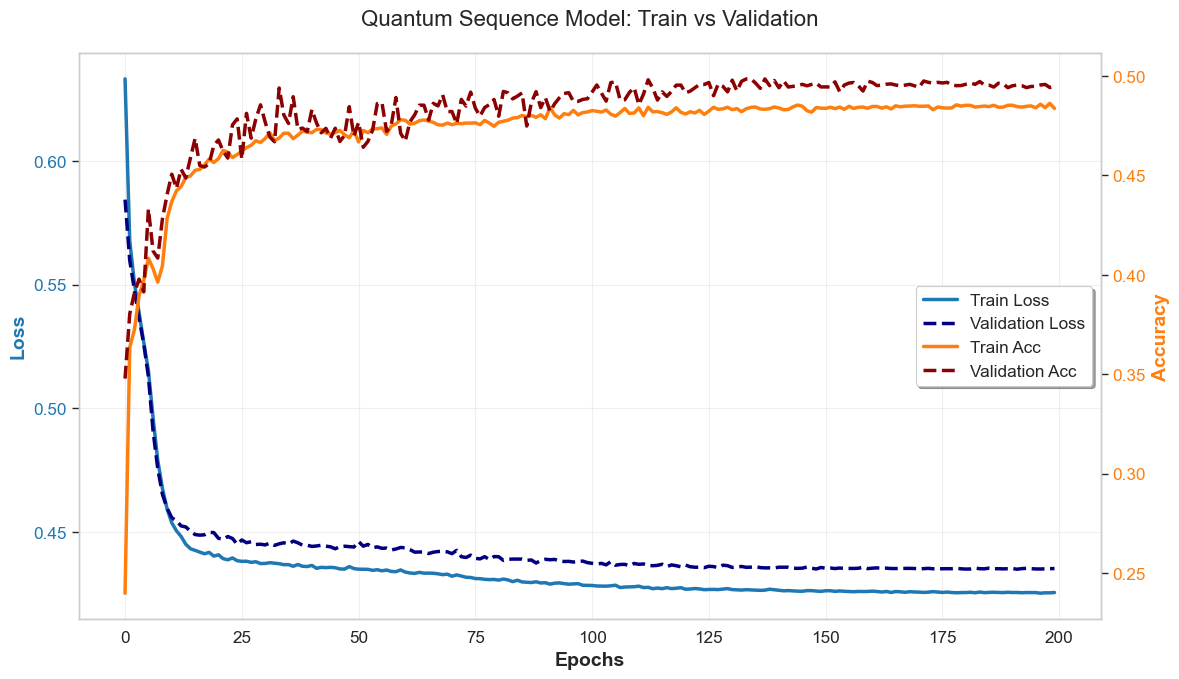

In [ ]:
# Set the aesthetic style
sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")

# Create figure and primary axis (Loss)
fig, ax1 = plt.subplots(figsize=(12, 7))

# --- Plot Loss (Left Axis) ---
color_train_loss = 'tab:blue'
color_val_loss = 'navy'

ax1.set_xlabel('Epochs', fontsize=14, fontweight='bold')
ax1.set_ylabel('Loss', color=color_train_loss, fontsize=14, fontweight='bold')

# Train Loss (Solid)
line1 = ax1.plot(loss_history, color=color_train_loss, linewidth=2.5, label='Train Loss')
# Val Loss (Dashed)
line2 = ax1.plot(val_loss_history, color=color_val_loss, linewidth=2.5, linestyle='--', label='Validation Loss')

ax1.tick_params(axis='y', labelcolor=color_train_loss)
ax1.grid(True, alpha=0.3)

# --- Plot Accuracy (Right Axis) ---
ax2 = ax1.twinx()
color_train_acc = 'tab:orange'
color_val_acc = 'darkred'

ax2.set_ylabel('Accuracy', color=color_train_acc, fontsize=14, fontweight='bold')

# Train Accuracy (Solid)
line3 = ax2.plot(acc_history, color=color_train_acc, linewidth=2.5, label='Train Acc')
# Val Accuracy (Dashed)
line4 = ax2.plot(val_acc_history, color=color_val_acc, linewidth=2.5, linestyle='--', label='Validation Acc')

ax2.tick_params(axis='y', labelcolor=color_train_acc)
ax2.grid(False)

# --- Combined Legend ---
lines = line1 + line2 + line3 + line4
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right', frameon=True, fancybox=True, shadow=True)

# Title and Layout
plt.title('Quantum Sequence Model: Train vs Validation', fontsize=16, pad=20)
plt.tight_layout()

# Save
plt.savefig(f"../generation/training_validation_curve_{N_MOLECS}_{fecha}.png", dpi=300, bbox_inches='tight')
plt.show()

## Final Test Phase: Unbiased Evaluation

This section performs the final evaluation of the optimized model on the **Test Set**, which has been completely withheld during the training and hyperparameter tuning phases.

**Objective:** To report the true generalization performance of the model on unseen data.

**Process:**
1.  **Load Best Model:** We load the model parameters that achieved the lowest validation loss.
2.  **Conditioned Generation:** For each set of molecular properties (LogP, QED, MW) in the Test Set, we generate a new molecule.
3.  **Metric Calculation:** We compute standard generative metrics:
    * **Validity:** Percentage of generated sequences that decode to valid chemical structures.
    * **Uniqueness:** Percentage of valid molecules that are unique.
    * **Novelty:** Percentage of valid molecules that do not appear in the Training Set.

In [ ]:
# Load best model parameters
ckpt_dir = '../data/params/'
with open(os.path.join(ckpt_dir, f"selfies_params_{N_MOLECS}_BEST.pkl"), "rb") as f:
    combined_params = pickle.load(f)

In [ ]:
@partial(jax.jit, static_argnums=(4,))
def calculate_nll_step(params, x_bits_batch, prop_batch, y_target_indices, PAD_index):
    """
    Calculates the Negative Log-Likelihood (NLL) for a batch of sequences.
    """
    # Embeddings & Position
    x_indices = jax.vmap(jax.vmap(bits_to_index))(x_bits_batch)
    input_embeddings = params['embedding_table'][x_indices]
    
    L = input_embeddings.shape[1]
    positions = jnp.arange(L)[None, :]
    dim_indices = jnp.arange(EMBEDDING_SIZE)
    # Calculate sinusoidal position encodings
    exponent = (dim_indices // 2) * 2 / EMBEDDING_SIZE
    denom = 10000 ** exponent
    angles = positions[..., None] / denom
    pos_enc = jnp.where(dim_indices % 2 == 0, jnp.sin(angles), jnp.cos(angles))
    x_i_pos = input_embeddings + pos_enc
    
    # Attention Projections
    Q = x_i_pos @ params['W_Q']
    K = x_i_pos @ params['W_K']
    V = x_i_pos @ params['W_V']
    
    # Attention calculation
    output_context = batched_causal_attention(Q, K, V)

    # Quantum Model Prediction
    pred_probs, _ = batch_predict(
        params, x_bits_batch, prop_batch, output_context
    )

    # Calculate Pure NLL (No Property Loss)
    vocab_size = pred_probs.shape[-1]
    flat_probs = pred_probs.reshape(-1, vocab_size)
    flat_targets = y_target_indices.reshape(-1)
    target_one_hot = jax.nn.one_hot(flat_targets, vocab_size)
    
    # NLL = -Sum( log(probability of correct token) )
    per_token_nll = -jnp.sum(target_one_hot * jnp.log(flat_probs + 1e-10), axis=-1)
    
    # Mask Padding
    mask = (flat_targets != PAD_index).astype(jnp.float32)
    return jnp.sum(per_token_nll * mask), jnp.sum(mask)


def get_test_set_nll(params, test_x, test_props, test_y):
    """ 
    Computes the average NLL per token over the test dataset.
    Args:
        params: Model parameters
        test_x: Test input bits (N, L, 5)
        test_props: Test molecular properties (N, 3)
        test_y: Test target token indices (N, L)
    Returns:
        Average NLL per token (scalar)
    """
    total_nll = 0.0
    total_tokens = 0.0
    
    # Loop through the dataset
    for i in range(0, len(test_x), BATCH_SIZE):
        # Calculate end index
        idx_end = min(i + BATCH_SIZE, len(test_x))
        
        # Create the batch
        batch_x = test_x[i:idx_end]
        batch_p = test_props[i:idx_end]
        batch_y = test_y[i:idx_end]
        
        # Skip empty batches (edge case)
        if len(batch_x) == 0: 
            continue

        # Calculate NLL for the batch
        nll, toks = calculate_nll_step(params, batch_x, batch_p, batch_y, PAD_index)
        
        total_nll += float(nll)
        total_tokens += float(toks)
        
    # Return average NLL per token
    return total_nll / total_tokens

# Calculate NLL on the Test Set
test_nll = get_test_set_nll(combined_params, X_bits_test, Props_test, Y_ind_test)
print(f"Test Set Average NLL per token: {test_nll:.4f}")


Test Set Average NLL per token: 1.9708


In [ ]:
def molecule_stochastic_generation(key, props, combined_params, temperature=0.7):
    """
    Generate a molecule in SELFIES format using the trained model.
    Args:
        key: JAX PRNGKey for randomness.
        props: Molecular properties (shape: 3,).
        combined_params: Dictionary of trained model parameters.
        temperature: Sampling temperature for diversity.
    Returns:
        generated_bits: List of jnp.ndarray, each of shape (BITS_PER_TOKEN,).
    """
    embedding_table = combined_params['embedding_table']
    W_Q = combined_params['W_Q']
    W_K = combined_params['W_K']
    W_V = combined_params['W_V']
    theta_params = combined_params['theta']
    theta_prop = combined_params['theta_prop']
    sigma_params = combined_params['sigma']
    
    generated_bits = []
    
    # Store the projected Keys and Values for history
    past_Ks = []
    past_Vs = []
    
    current_token_index = SOS_index
    current_token_bits = jnp.array(list(map(int, format(SOS_index, f'0{BITS_PER_TOKEN}b'))), dtype=jnp.int32)
    local_rng = key 
    
    for t in range(MAX_LEN):
        local_rng, subkey = random.split(local_rng)

        # 1. Embedding & Position Encoding (Same as Training)
        x_token = current_token_bits 
        current_token_index = bits_to_index(x_token)
        x_i = embedding_table[current_token_index]

        # Position matches 't' because we are at the t-th step of the sequence
        position = t
        dim_indices = jnp.arange(EMBEDDING_SIZE)
        positional_encoding = jnp.where(
            dim_indices % 2 == 0,
            jnp.sin(position / (10000 ** (dim_indices / EMBEDDING_SIZE))),
            jnp.cos(position / (10000 ** ((dim_indices-1) / EMBEDDING_SIZE)))
        )
        x_i_pos = x_i + positional_encoding

        # 2. Projections
        Q_i = x_i_pos @ W_Q
        K_i = x_i_pos @ W_K
        V_i = x_i_pos @ W_V
        
        # 3. Update History 
        # Add current K_i and V_i to history BEFORE computing attention
        past_Ks.append(K_i)
        past_Vs.append(V_i)

        # Attention Calculation
        # Stack lists into arrays for matrix multiplication
        # K_mat shape: (t+1, proj_dim)
        K_mat = jnp.stack(past_Ks)
        V_mat = jnp.stack(past_Vs)
        
        d_k = W_Q.shape[-1]
        
        # Calculate scores against ALL tokens seen so far (including current)
        # Q_i (dim) @ K_mat.T (dim, t+1) -> (t+1) scores
        scores = jnp.matmul(Q_i, K_mat.T) / jnp.sqrt(d_k)
        weights = jnn.softmax(scores)
        
        # Context vector
        output_i = jnp.dot(weights, V_mat)

        # 5. Prediction (Quantum Model)
        pred_probs, _ = autoregressive_model(x_token, props, theta_params, theta_prop, sigma_params, output_i, combined_params['prop_scaling'])
        
        # 6. Tempering & Sampling
        logits = jnp.log(pred_probs[:VOCABULARY_SIZE] + 1e-10)

        logit_mask = jnp.zeros((VOCABULARY_SIZE,))
        logit_mask = logit_mask.at[PAD_index].set(-1e9)
        logit_mask = logit_mask.at[SOS_index].set(-1e9)
        
        masked_logits = logits + logit_mask
        tempered_logits = masked_logits / temperature
        tempered_probs = jnn.softmax(tempered_logits)
        
        token_indices = jnp.arange(VOCABULARY_SIZE)
        next_index = random.choice(subkey, token_indices, p=tempered_probs)

        next_bits_str = format(int(next_index), f'0{BITS_PER_TOKEN}b')
        next_bits = jnp.array([int(b) for b in next_bits_str], dtype=jnp.int32)

        if int(next_index) == EOS_index:
            break

        generated_bits.append(next_bits)
        
        # Update for next iteration
        current_token_bits = next_bits 

    return generated_bits


def bits_to_selfies_smiles(generated_bits):
    """
    Convert a list of bit arrays to SELFIES string and SMILES string.
    Args:
        generated_bits: List of jnp.ndarray, each of shape (BITS_PER_TOKEN,)
    Returns:
        Tuple of:
            - selfies_str: Generated SELFIES string
            - smiles_str: Decoded SMILES string (or None if decoding fails)
    """
    selfies_tokens = []
    for bits in generated_bits:
        index = int("".join(map(str, bits)), 2)
        
        if index >= VOCABULARY_SIZE:
            break

        token = ALPHABET[int(index)]
        if token == '<EOS>':
            break
        selfies_tokens.append(token)
    
    selfies_str = ''.join(selfies_tokens)
    # Use error handling for decoding
    try:
        smiles_str = sf.decoder(selfies_str)
    except:
        smiles_str = None
    return selfies_str, smiles_str

In [ ]:
def calculate_validity(generated_smiles_list):
    """
    Calculates the percentage of generated sequences that are chemically valid.
    Returns the score and the list of valid RDKit molecules (as SMILES).
    """
    valid_smiles = []
    for smi in generated_smiles_list:
        # Basic check: string is not None or empty
        if not smi:
            continue
        
        # RDKit check
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            valid_smiles.append(smi)
            
    if len(generated_smiles_list) == 0:
        return 0.0, []
        
    score = len(valid_smiles) / len(generated_smiles_list)
    return score, valid_smiles


def calculate_uniqueness(valid_smiles_list):
    """
    Calculates the percentage of unique molecules among the VALID ones.
    """
    if len(valid_smiles_list) == 0:
        return 0.0
    
    unique_smiles = set(valid_smiles_list)
    score = len(unique_smiles) / len(valid_smiles_list)
    return score


def calculate_novelty(valid_smiles_list, training_smiles_set):
    """
    Calculates the percentage of valid molecules that do NOT appear in the training set.
    """
    if len(valid_smiles_list) == 0:
        return 0.0
    
    # Count how many generated molecules are NOT in the training set
    novel_mols = [s for s in valid_smiles_list if s not in training_smiles_set]
    
    score = len(novel_mols) / len(valid_smiles_list)
    return score



def load_training_smiles_for_novelty(train_csv_path):
    """
    Reads the Training CSV tokens and converts them back to SMILES 
    to build the reference set for Novelty.
    """
    print(f"Loading Training Data for Novelty check: {train_csv_path}")
    
    # --- FIX: Read everything as string to preserve "00000" format ---
    df = pd.read_csv(train_csv_path, dtype=str)
    
    training_smiles = set()
    
    # Get token columns
    token_cols = [c for c in df.columns if 'token_' in c]
    
    for _, row in df.iterrows():
        # Extract token bits
        tokens_bits = [row[col] for col in token_cols]
        
        mol_tokens = []
        for bit_str in tokens_bits:
            # Handle potential NaNs from string conversion
            if pd.isna(bit_str) or bit_str == 'nan': 
                continue
            
            try:
                # Now bit_str is guaranteed to be a string like "00101"
                idx = int(bit_str, 2)
                
                if idx < len(ALPHABET):
                    token = ALPHABET[idx]
                    if token == '<EOS>': break
                    mol_tokens.append(token)
            except ValueError:
                continue # Skip malformed bits
        
        # Decode SELFIES to SMILES
        try:
            smi = sf.decoder("".join(mol_tokens))
            if smi:
                training_smiles.add(smi)
        except:
            continue
            
    print(f"Found {len(training_smiles)} unique molecules in Training Set.")
    return training_smiles

In [ ]:
# Load Reference Data
training_set_smiles = load_training_smiles_for_novelty(data_path_train)

# Load Test Data
test_df = pd.read_csv(data_path_test)
print(f"Loaded Test Data: {len(test_df)} samples")


print("Starting Generation...")
start_time = time.time()

generated_smiles_list = []
target_props_list = []

# JAX Random Key
key = jax.random.PRNGKey(int(time.time()))

# Loop through the Test Set
# Generate 1 molecule for every row in the test set, using THAT row's properties
for i, row in test_df.iterrows():
    
    # 1. Get Properties from Test Data
    props = jnp.array([row['logP'], row['qed'], row['mw']], dtype=jnp.float32)
    
    # 2. Split Key for randomness
    key, subkey = jax.random.split(key)
    
    # 3. Generate molecule using the BEST parameters loaded
    gen_bits = molecule_stochastic_generation(
        subkey, 
        props, 
        combined_params, 
        temperature=0.7)
    
    # 4. Decode to SMILES
    _, gen_smi = bits_to_selfies_smiles(gen_bits)
    
    generated_smiles_list.append(gen_smi)
    target_props_list.append(props)
    
    if i % 50 == 0:
        print(f"Generated {i}/{len(test_df)}")

print(f"Generation finished in {time.time() - start_time:.2f}s")


Loading Training Data for Novelty check: ../data/structured_data_selfies_1000_train.csv
Found 648 unique molecules in Training Set.
Loaded Test Data: 143 samples
Starting Generation...
Generated 0/143
Generated 50/143
Generated 100/143
Generation finished in 1107.18s


In [ ]:
print(generated_smiles_list)

['C1=CN1CC2CC=CC=CCN=CN=C2', 'CC#CCC=CC=CC', 'CI', 'C1=CC(C)NC1C=O', 'COC=CCC=C', 'CNC=C', 'C12CNOCC3CC1C=CC=CCC=C32', 'C12=CN=C1C2C3C(S)C=CN3N', 'NC=C=C(C)CCCCC=CC=C', 'C1(C=CC=C=O)=CC=C1', 'CC=CC=CCC=CCC=CC1=CC=C1', 'C=CC=CC=C(C)C=S', 'C=1C=CCC(C)CC=C=1', 'P(C(CC)OCCC1C)=CC=C1C', 'C1N=C1CC#C', 'C12(C)CC1C=CC(CC=C2C)(N)CI', '', 'N=C(C)C1C2C=CC=C2CCCC1', 'N#C', 'NC=C=C', 'CN=C', 'CC=C(C)C=NCCCCC=CC=CN=C', 'CCC=CC1=CC=CC=C1CC(=O)OCC#N', 'C=1NCC=C=1', 'C1=CC=C1', 'CCOCCC=NC', 'C1C(C)C=CCCC=CC(Cl)C1', 'N1=NCC2=C(C)CC=C2C1', 'N#PC=NPN', 'C#C', 'CC=CC=CC=CCC=CC=C1CCCCC1', 'C1=CC=C1CC=CC=CC=CCCCNCl', 'CC=CC=C=NC', 'C1(=O)OCC=C=C=C1CN', 'CC=CC=CC=CCCCCF', 'C1#CCNCO1', 'C=NCC=C', 'CCCCCC1C=C(O)C=C1', 'C1(C)NCC=CC=CCC=C1C=CN=CC=C=NCl', 'C1=CC=CC=COCC=CC=C1', 'C1#C[PH1](C)C1CC=CCC', 'C=CC=CC=CCP', 'C12(C)C#CC1C=CC=C2', 'CC=1N(N)C=C=1', 'CCl', 'O1C=C(C)CC1CC2C(C=CC=C2C)=O', 'CNC=CC1=C2C=CC=C2COC1C[NH1]', 'C1=2C=CC=C1C=CC=2N', 'OCCC=CC=CC=CC#CF', 'C1C=CC=NS=CSCC=CC=CC1=O', 'N1CCCCC2CCC=C2C1(C)C', 

In [ ]:
# Calculate Metrics
print("\n--- Calculating Metrics ---")

# Validity
val_score, valid_mols = calculate_validity(generated_smiles_list)

# Uniqueness (Calculated only on valid molecules)
uniq_score = calculate_uniqueness(valid_mols)

# Novelty (Calculated only on valid molecules vs Training Set)
nov_score = calculate_novelty(valid_mols, training_set_smiles)


print("="*40)
print(f"FINAL RESULTS (Model: {N_MOLECS}_BEST)")
print("="*40)
print(f"Number of generated samples: {len(generated_smiles_list)}")
print(f"Validity:   {val_score:.2%}  ({len(valid_mols)} valid)")
print(f"Uniqueness: {uniq_score:.2%}")
print(f"Novelty:    {nov_score:.2%}")
print("="*40)



--- Calculating Metrics ---
FINAL RESULTS (Model: 1000_BEST)
Number of generated samples: 143
Validity:   97.90%  (140 valid)
Uniqueness: 97.14%
Novelty:    100.00%


In [ ]:

# Optional: Save generated molecules to CSV for inspection
results_df = pd.DataFrame({
    'Target_LogP': [float(p[0]) for p in target_props_list],
    'Target_QED': [float(p[1]) for p in target_props_list],
    'Target_MW': [float(p[2]) for p in target_props_list],
    'Generated_SMILES': generated_smiles_list
})
results_df.to_csv(f"../generation/final_results_{N_MOLECS}_{fecha}.csv", index=False)
print("Saved generation results to CSV.")

Saved generation results to CSV.


In [ ]:
from rdkit.Chem import Descriptors, QED
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_generated_properties(results_df):
    """
    Calculates actual physicochemical properties for the generated SMILES.
    """
    print("Calculating properties for generated molecules...")
    
    actual_logp = []
    actual_qed = []
    actual_mw = []
    valid_indices = []

    for idx, row in results_df.iterrows():
        smi = row['Generated_SMILES']
        if not smi: # Skip empty
            continue
            
        mol = Chem.MolFromSmiles(smi)
        if mol:
            # Calculate properties using RDKit
            actual_logp.append(Descriptors.MolLogP(mol))
            actual_qed.append(QED.qed(mol))
            actual_mw.append(Descriptors.ExactMolWt(mol))
            valid_indices.append(idx)
            
    # Create a new DataFrame for valid generated molecules
    gen_props_df = pd.DataFrame({
        'LogP': actual_logp,
        'QED': actual_qed,
        'MW': actual_mw,
        'Source': 'Generated'
    })
    
    return gen_props_df, valid_indices


In [ ]:
def plot_property_distributions(combined_df, save_path=None):
    """
    Plots the distribution of properties for Generated vs Test Set molecules.
    """
    # Set style
    sns.set_context("paper", font_scale=1.4)
    sns.set_style("whitegrid")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    properties = ['LogP', 'QED', 'MW']
    colors = {'Test Set (Ground Truth)': 'grey', 'Generated': 'tab:blue'}
    
    for i, prop in enumerate(properties):
        ax = axes[i]
        
        # Plot KDE (Kernel Density Estimate)
        sns.kdeplot(
            data=combined_df, 
            x=prop, 
            hue='Source', 
            fill=True, 
            common_norm=False, 
            palette=colors,
            alpha=0.3, 
            linewidth=2.5,
            ax=ax
        )
        
        ax.set_title(f'{prop} Distribution', fontweight='bold')
        ax.set_xlabel(prop)
        ax.set_ylabel('Density')
        
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    plt.show()


Calculating properties for generated molecules...
Plot saved to ../generation/property_distribution_1000_29112025.png


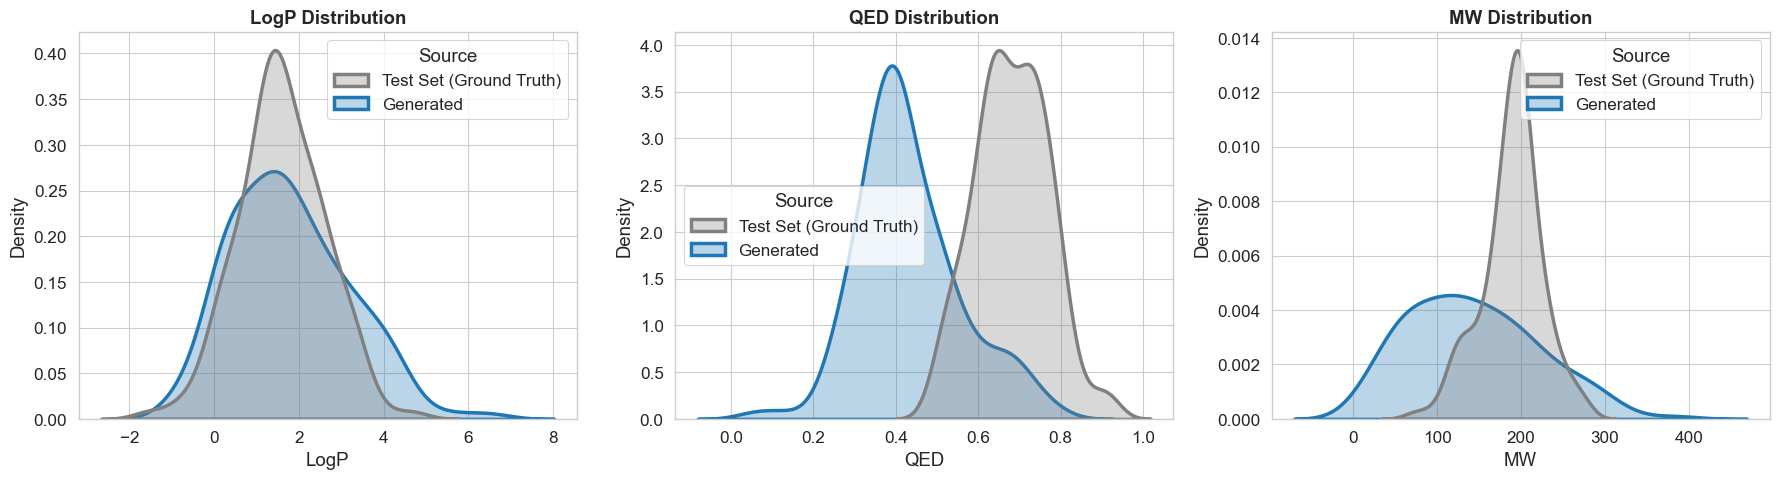

In [ ]:
# Get Target Properties and DE-NORMALIZE them
gen_props_df, valid_indices = calculate_generated_properties(results_df)
test_props_df = results_df.loc[valid_indices, ['Target_LogP', 'Target_QED', 'Target_MW']].copy()

# Apply de-normalization (using the min/max values from your load_molecules.ipynb)
# You need to make sure min_logp, max_logp, etc. are available here!
test_props_df['Target_LogP'] = test_props_df['Target_LogP'].apply(lambda x: denormalize(x, min_logp, max_logp))
test_props_df['Target_QED'] = test_props_df['Target_QED'].apply(lambda x: denormalize(x, min_qed, max_qed))
test_props_df['Target_MW'] = test_props_df['Target_MW'].apply(lambda x: denormalize(x, min_mw, max_mw))

test_props_df.columns = ['LogP', 'QED', 'MW']
test_props_df['Source'] = 'Test Set (Ground Truth)'

combined_df = pd.concat([test_props_df, gen_props_df], axis=0) 

# Plot and Save
save_plot_path = f"../generation/property_distribution_{N_MOLECS}_{fecha}.png"
plot_property_distributions(combined_df, save_path=save_plot_path)

Ranking molecules by Target-Match Accuracy...
Drawing top 9 most accurate generations...
Saved image to ../generation/best_matching_molecules_1000.png


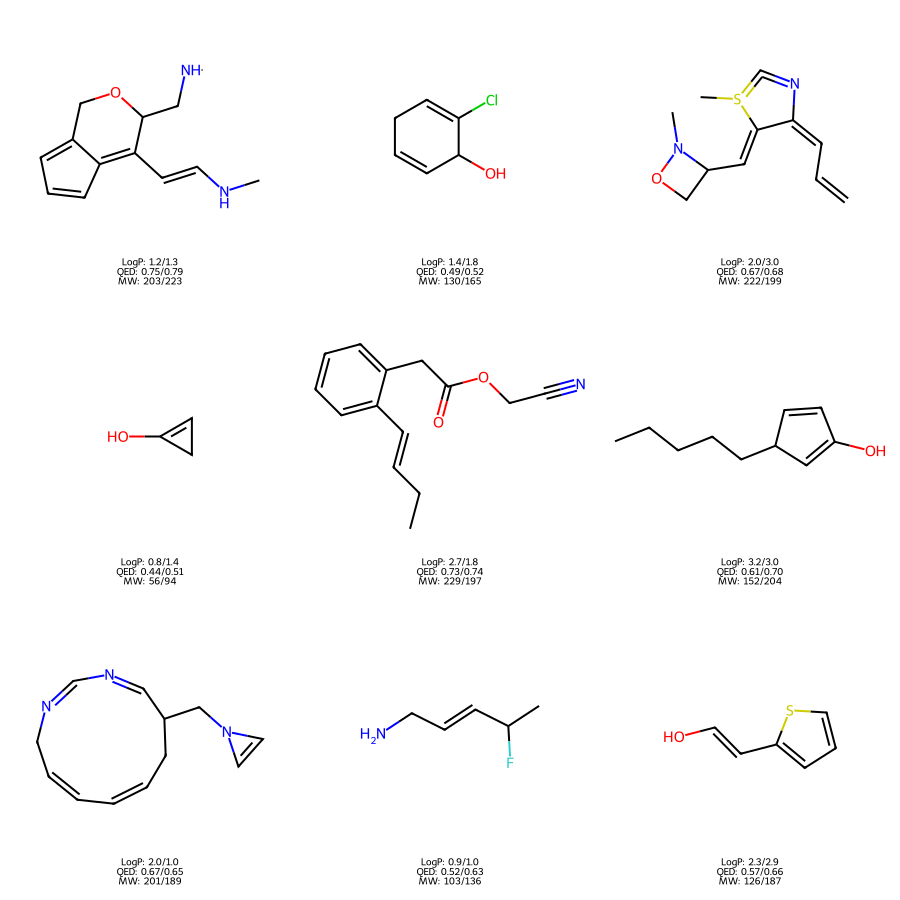

In [ ]:
RESULTS_PATH = f"../generation/final_results_{N_MOLECS}_{fecha}.csv"
results_df = pd.read_csv(RESULTS_PATH)

print("Ranking molecules by Target-Match Accuracy...")

molecules_to_draw = []
errors = []

for idx, row in results_df.iterrows():
    smi = row['Generated_SMILES']
    if not smi or pd.isna(smi):
        continue
        
    mol = Chem.MolFromSmiles(smi)
    if not mol:
        continue

    # A. Calculate Actual Properties
    act_logp = Descriptors.MolLogP(mol)
    act_qed = QED.qed(mol)
    act_mw = Descriptors.ExactMolWt(mol)
    
    # B. Get Target Properties (De-normalized)
    # Note: Ensure your CSV saved them as Normalized. 
    # If you saved de-normalized values already, skip the 'denorm' call.
    tgt_logp = denormalize(row['Target_LogP'], min_logp, max_logp)
    tgt_qed = denormalize(row['Target_QED'], min_qed, max_qed)
    tgt_mw = denormalize(row['Target_MW'], min_mw, max_mw)

    
    # C. Calculate Error (Mean Squared Error between Target and Actual)
    # We normalize the differences so MW doesn't dominate the error score
    # (e.g. MW error of 10 is small, but QED error of 10 is impossible)
    diff_logp = (act_logp - tgt_logp) ** 2
    diff_qed = (act_qed - tgt_qed) ** 2 * 100 # Scale up QED importance
    diff_mw = ((act_mw - tgt_mw) / 100) ** 2  # Scale down MW importance
    
    total_error = diff_logp + diff_qed + diff_mw
    
    molecules_to_draw.append({
        'mol': mol,
        'smiles': smi,
        'error': total_error,
        'legend': f"LogP: {act_logp:.1f}/{tgt_logp:.1f}\nQED: {act_qed:.2f}/{tgt_qed:.2f}\nMW: {act_mw:.0f}/{tgt_mw:.0f}"
    })

# --- 4. Sort and Select Top K ---
# Sort by lowest error (Best Match)
best_molecules = sorted(molecules_to_draw, key=lambda x: x['error'])[:9] # Top 9

# --- 5. Draw Grid ---
print(f"Drawing top {len(best_molecules)} most accurate generations...")

img = Draw.MolsToGridImage(
    [x['mol'] for x in best_molecules],
    molsPerRow=3,
    subImgSize=(300, 300),
    legends=[x['legend'] for x in best_molecules], # Shows Actual / Target
    returnPNG=False
)

# Save
img_path = f"../generation/best_matching_molecules_{N_MOLECS}.png"
img.save(img_path)
print(f"Saved image to {img_path}")

# Display (if in notebook)
display(img)

------------------------------------------------------------------

## Stochastic Generation with Tempering

To generate novel molecules, we run the trained model autoregressively.
* **Tempering:** We apply a temperature factor $T$ to the logits ($p_i = \frac{\exp(z_i/T)}{\sum \exp(z_j/T)}$) to control the diversity of the output.
* **Masking:** We explicitly mask invalid start/pad tokens to ensure the generator produces syntactically valid sequences.

In [ ]:
N_MOLECS = 100  # Number of molecules to generate
MASTER_KEY = jax.random.PRNGKey(42)  # Fixed key for reproducibility
TEMPERATURE = 0.6  # Sampling temperature

# Target properties (mid-range example normalized to [0, pi])
desired_logp = 1.2
desired_qed = 0.71
desired_mw = 205.0

norm_logp = normalize(desired_logp, min_logp, max_logp)
norm_qed = normalize(desired_qed, min_qed, max_qed)
norm_mw = normalize(desired_mw, min_mw, max_mw)
desired_props = jnp.array([norm_logp, norm_qed, norm_mw], dtype=jnp.float32)

print(f"Target Properties (Normalized to [0, pi]):")
print(f"   LogP: {norm_logp:.3f}, QED: {norm_qed:.3f}, MW: {norm_mw:.3f}\n")


def generate_molecules(props, params):
    selfies_list = []
    smiles_list = []
    keys = jax.random.split(MASTER_KEY, N_MOLECS)
    for i in range(N_MOLECS):
        rng_i = keys[i]
        generated_bits = molecule_stochastic_generation(rng_i, props, params, temperature=TEMPERATURE)
        generated_selfies, generated_smiles = bits_to_selfies_smiles(generated_bits)
        selfies_list.append(generated_selfies)
        smiles_list.append(generated_smiles)
    return selfies_list, smiles_list

selfies_list, smiles_list = generate_molecules(desired_props, combined_params)

Target Properties (Normalized to [0, pi]):
   LogP: 1.386, QED: 1.571, MW: 1.841



In [ ]:
def analyze_molecule_properties(selfies_list, smiles_list, target_logp, target_qed, target_mw):
    """
    Calculates and prints the physicochemical properties for generated molecules,
    comparing them directly against the denormalized targets.
    Args:
        selfies_list: List of generated SELFIES strings
        smiles_list: List of generated SMILES strings
        target_logp: Target LogP value (denormalized)
        target_qed: Target QED value (denormalized)
        target_mw: Target Molecular Weight (denormalized)
    Returns:
        DataFrame with properties of generated molecules and comparison to target
    """
    results = []
    
    # Print Denormalized Target Properties
    print(f"\n--- Target Properties ---")
    print(f"LogP: {target_logp:.2f}")
    print(f"QED: {target_qed:.2f}")
    print(f"MW: {target_mw:.2f} g/mol")
    print("-" * 35)

    for i, (smiles, selfies) in enumerate(zip(smiles_list, selfies_list)):
        # Handle empty/invalid SMILES from generation failure
        if not smiles:
            results.append({"Molecule": i+1, "SMILES": "N/A", "LogP": np.nan, "QED": np.nan, "MW": np.nan})
            continue

        mol = Chem.MolFromSmiles(smiles)

        if mol is not None:
            try:
                logp = Descriptors.MolLogP(mol)
                qed_score = QED.qed(mol)
                mw = Descriptors.ExactMolWt(mol)

                results.append({
                    "Molecule": i+1,
                    "SELFIES": selfies,
                    "SMILES": smiles,
                    "LogP": logp,
                    "QED": qed_score,
                    "MW": mw,
                    "Validity": "Valid"
                })
            except Exception:
                 results.append({"Molecule": i+1, "SELFIES": selfies, "SMILES": smiles, "LogP": np.nan, "QED": np.nan, "MW": np.nan, "Validity": "Error"})
        else:
            results.append({"Molecule": i+1, "SELFIES": selfies, "SMILES": smiles, "LogP": np.nan, "QED": np.nan, "MW": np.nan, "Validity": "Invalid"})

    # Create and display the DataFrame
    df = pd.DataFrame(results)
    
    # Add a row for the target properties for easy comparison
    target_row = pd.Series({
        "Molecule": "TARGET", 
        "SELFIES": "TARGET",
        "SMILES": "TARGET", 
        "LogP": target_logp, 
        "QED": target_qed, 
        "MW": target_mw
    }, name="TARGET").to_frame().T
    
    # Concatenate the target row and the results for visual comparison
    df_styled = pd.concat([target_row.set_index('Molecule'), df.set_index('Molecule')])
    
    # Format numerical columns for presentation
    df_styled = df_styled.apply(pd.to_numeric, errors='ignore').round(2)
    
    return df_styled

df_styled = analyze_molecule_properties(selfies_list, smiles_list, desired_logp, desired_qed, desired_mw)

# Save the results to a CSV file
output_csv_path = f"../generation/generated_selfies_{N_MOLECS}_{fecha}.csv"
df_styled.to_csv(output_csv_path)


--- Target Properties ---
LogP: 1.20
QED: 0.71
MW: 205.00 g/mol
-----------------------------------


/var/folders/8w/bmwl8d950jz75tsw3l1xlnm80000gn/T/ipykernel_63859/657521859.py:68: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_styled = df_styled.apply(pd.to_numeric, errors='ignore').round(2)


In [ ]:
def get_top_molecules(selfies_list, smiles_list, top_k=5, min_mw=150.0, min_qed=0.5):
    """
    Filters generated molecules by validity and properties, then returns the top K
    sorted by QED (drug-likeness).
    Args:
        selfies_list: List of generated SELFIES strings
        smiles_list: List of generated SMILES strings
        top_k: Number of top molecules to return
        min_mw: Minimum molecular weight to consider
        min_qed: Minimum QED score to consider
    Returns:
        DataFrame of top K molecules with their properties
    """
    valid_molecules = []

    print(f"Analyzing {len(smiles_list)} generated molecules...")

    for i, (smiles, selfies) in enumerate(zip(smiles_list, selfies_list)):
        # 1. Basic Validity Check
        if not smiles:
            continue
            
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue

        try:
            # 2. Calculate Properties
            mw = Descriptors.ExactMolWt(mol)
            qed_score = QED.qed(mol)
            logp = Descriptors.MolLogP(mol)

            # 3. Apply Filters (The "Quality Control")
            # We want molecules that are large enough (MW > 150) to be interesting
            # and drug-like enough (QED > 0.5) to be valid candidates.
            if mw >= min_mw and qed_score >= min_qed:
                valid_molecules.append({
                    "Index": i,
                    "SMILES": smiles,
                    "SELFIES": selfies,
                    "LogP": logp,
                    "QED": qed_score,
                    "MW": mw
                })
        except Exception:
            continue

    # 4. Sort by QED (Best Drug-Likeness First)
    # You could also sort by similarity to target LogP if preferred
    valid_molecules.sort(key=lambda x: x['QED'], reverse=True)

    # 5. Select Top K
    top_molecules = valid_molecules[:top_k]
    
    print(f"Found {len(valid_molecules)} molecules passing filters.")
    print(f"Showing top {len(top_molecules)}:")

    return pd.DataFrame(top_molecules)


top_10_df = get_top_molecules(selfies_list, smiles_list, top_k=10)

# Display
pd.set_option('display.max_colwidth', 60) # Make columns wide enough to see strings
display(top_10_df)

Analyzing 100 generated molecules...
Found 22 molecules passing filters.
Showing top 10:


,Index,SMILES,SELFIES,LogP,QED,MW
0,37,C1CCOCC=CC(N)=CC2=CC=C3C=CC=C3C1=C2N,[C][C][C][O][C][C][=C][C][Branch1][C][N][=C][C][=C][C][=...,3.1922,0.778758,280.157563
1,55,C=CC1=CC=CC2=C(C)C=C2CC3CCC[NH1]C31,[C][=C][C][=C][C][=C][C][=C][Branch1][C][C][C][=C][Ring1...,3.6834,0.735698,239.167400
2,71,OCC=CC=CCC=CC=CCC1=CC=CC=C1OC,[O][C][C][=C][C][=C][C][C][=C][C][=C][C][C][=C][C][=C][C...,3.8449,0.727124,270.161980
3,56,CC=CC1=C(C=CC=C1C=O)CC,[C][C][=C][C][=C][Branch1][=N][C][=C][C][=C][Ring1][=Bra...,3.0946,0.643396,174.104465
4,18,BrNCC(F)CC,[Br][N][C][C][=Branch1][C][F][Branch1][C][C],1.6340,0.634418,168.990240
5,46,CCN(C)CCC1CC=CC=C1C=O,[C][Branch1][Ring1][Ring2][N][C][C][N][Branch1][C][C][C]...,2.0296,0.622623,193.146664
6,87,C12CC=CC=C2C=CC3=C1[NH1]NC=C3,[C][C][C][=C][C][=C][Branch1][N][C][=C][C][=C][Ring1][N]...,1.9343,0.600836,184.100048
7,2,C(I)C=CN(C)C=CN,[C][Branch1][Cl][I][C][=C][N][Branch1][C][=C][C][=C][Bra...,1.2968,0.592679,237.996696
8,38,C1CCCC=C(C)NC=C1Cl,[C][C][C][C][C][=C][Branch1][C][C][=N][C][=C][Ring1][N][...,3.1340,0.590727,171.081477
9,50,C=C1C(NCC=CC=C2C)=CC=C12,[C][=C][C][Branch1][Branch2][N][C][C][=C][C][=C][C][=C][...,2.4722,0.590080,171.104799


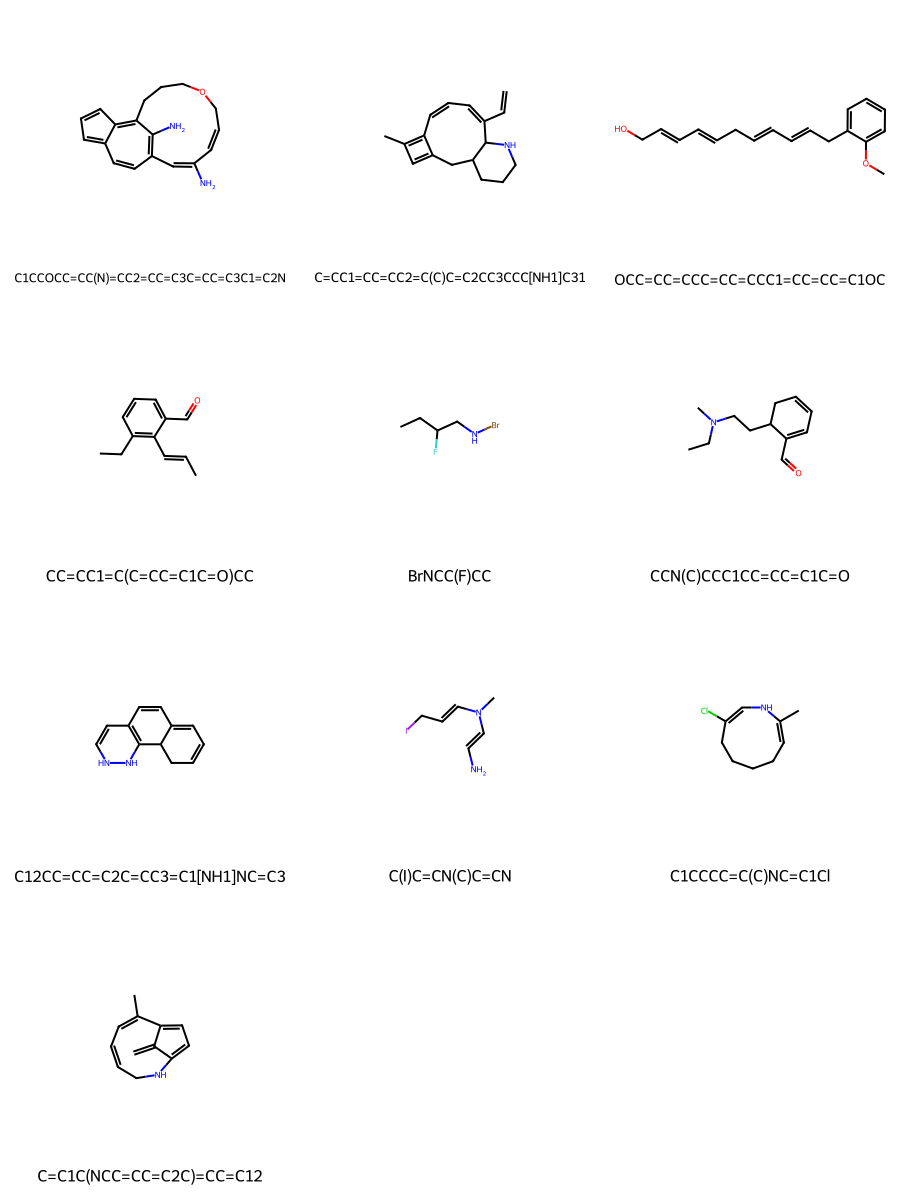

In [ ]:
# Generate the Molecules
mols = [Chem.MolFromSmiles(s) for s in top_10_df['SMILES']]

# Generate the Grid Image
img = Draw.MolsToGridImage(
    mols, 
    molsPerRow=3, 
    subImgSize=(300, 300), 
    legends=[top_10_df.iloc[i]['SMILES'] for i in range(len(mols))],
    returnPNG=False 
)

img.save(f"../generation/best_molecules_{N_MOLECS}_{fecha}.png")

display(img)